# Necessary

- Create VE
- Create dataset

In [1]:
# Enable autoreload extension
%load_ext autoreload
# Automatically reload all modules (except built-ins) before executing code
%autoreload 2

import sys
import os
sys.path.append(os.path.abspath("/home/gdallagl/myworkdir/ESMSec/utils"))  # Adds current folder to Python path

import utils.my_functions as mf
import utils.models as my_models
import utils.dataset as my_dataset
import utils.embeddings_functions as my_embs
import utils.scanning as my_scanning

import torch
import torch.nn as nn
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from transformers import AutoModel, AutoTokenizer
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from tqdm import tqdm
import seaborn as sns
import json
import os
from IPython.display import clear_output


print(torch.__version__)

2.5.0+cu121


In [2]:
# Configuration / hyperparameters
config = {
    "SEED": 42,             # Random seed

    "NUM_EPOCHS": 100,       # Total Epochs in training 150
    "EVAL_EPOCH_FREQ": 5,   # Evaluation frequency 5
    "BATCH_SIZE": 128,       # Batch size
    "LR": 1e-4,             # Learning rate 1e-5
    "LR_DECAY_GAMMA": 0.8,    # Learning rate decays
    "LR_DECAY_STEPS_EPOCHS": 2, # Learning rate decay steps
    "L2_REG": 0.01, # avoid to big weigths (imprve generalisation) (1 - weigths)

    "PROTEIN_MAX_LENGTH": 1000, # Max protein length (for ESM2)
    "PRETRAIN_ESM_CHECKPOINT_NAME": "facebook/esm2_t36_3B_UR50D",#"facebook/esm2_t33_650M_UR50D", #"facebook/esm2_t12_35M_UR50D", #"facebook/esm2_t6_8M_UR50D", # ESM2 model name --> if nto isntalled, autocally dowlaoded
    "PRETRAIN_ESM_CACHE_DIR": "/home/gdallagl/myworkdir/data/esm2-models", # ESM2 model cache dir
    "DEVICE": "cuda" if torch.cuda.is_available() else "cpu", # Device to use (cuda or cpu)

    "DATASET_PATH": "/home/gdallagl/myworkdir/ESMSec/data/cell_location/secreted_Uniprot-locations_03_dataset_final_sample-neg=False.csv",#"/home/gdallagl/myworkdir/data/cell_cycle/datasets/protein_classification_cluster_43_leiden_all_initial_loose.csv", #"/home/gdallagl/myworkdir/data/cell_cycle/datasets/protein_classification_cluster_43_leiden_all_initial_loose.csv", #"/home/gdallagl/myworkdir/ESMSec/data/secreted/dataset_lysoVSsecreted.csv", #'/home/gdallagl/myworkdir/ESMSec/data/cell_cycle/datasets/cc_dataset_final.csv', #"/home/gdallagl/myworkdir/ESMSec/data/cell_cycle/datasets/nucleolus_final_dataset.csv", #"/home/gdallagl/myworkdir/ESMSec/data/cell_cycle/cell-cycle-dataset_2:3.csv",  #"/home/gdallagl/myworkdir/ESMSec/data/cell_cycle/only-guaranteed_cell-cycle-dataset_2:3.csv", #"/home/gdallagl/myworkdir/ESMSec/data/cell_cycle/cell-cycle-dataset_2:3.csv", 
    
    "TYPE_HEAD":"MLP",# "attention", #"MLP", "LR", gating_transformer
    "TYPE_EMB_FOR_CLASSIFICATION": "cls", #"concat(agg_mean, agg_max)", #"contextualized_embs", #"concat(agg_mean, agg_max)",cls, stacked_linearized_all
    "FROM_PRECOMPUTED_EMBS": True,
}

# AUTOMATIC
config["PRECOMPUTED_EMBS_PATH"] = os.path.join( # all uniprot human and reviewed
    f"/home/gdallagl/myworkdir/ESMSec/data/UniProt/precomputed_embs",
    f"entire_reviewed_uniprot_{config['PRETRAIN_ESM_CHECKPOINT_NAME'].replace('/', '-')}_"
    f"{config['TYPE_EMB_FOR_CLASSIFICATION']}.safetensors"
)
config["PRECOMPUTED_EMBS_PATH_PROTEIN_NAMES"] =config["PRECOMPUTED_EMBS_PATH"].replace('.safetensors', '_names.json')

config["RESULTS_FOLDER_PATH"] = os.path.join( # all uniprot human and reviewed
        f"/home/gdallagl/myworkdir/ESMSec/data/model_results",
        f"{os.path.basename(config['DATASET_PATH']).replace('.csv', '')}"
)
os.makedirs(config["RESULTS_FOLDER_PATH"], exist_ok=True)

config["PATH_TO_SAVE_MODEL"] = os.path.join( # all uniprot human and reviewed
        config["RESULTS_FOLDER_PATH"],
        f"trained_model.pth"
)

# Initializations
random.seed(config["SEED"])
np.random.seed(config["SEED"])
torch.manual_seed(config["SEED"])
torch.backends.cudnn.benchmark = True 

# Instantiate ESM model

In [3]:
# Load pre-trained ESM model
#esm_model = AutoModel.from_pretrained(config["PRETRAIN_ESM_CHECKPOINT_NAME"],  cache_dir=config["PRETRAIN_ESM_CACHE_DIR"]).to(config["DEVICE"])
esm_model = AutoModel.from_pretrained(
    config["PRETRAIN_ESM_CHECKPOINT_NAME"], 
    cache_dir=config["PRETRAIN_ESM_CACHE_DIR"],
    weights_only=False  
).to(config["DEVICE"]) 

# Checj whcih model has been moded by AutoModel.from_pretrained()
print("\nESM model type", type(esm_model), "\n")

# Load relative tokenizer
tokenizer = AutoTokenizer.from_pretrained(config["PRETRAIN_ESM_CHECKPOINT_NAME"])

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t36_3B_UR50D and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



ESM model type <class 'transformers.models.esm.modeling_esm.EsmModel'> 



# Load dataset and Tokenize

In [4]:
data = pd.read_csv(config["DATASET_PATH"])

num_samples = data.shape[0]
num_classes = data.label.nunique() # ATTENTION: NOT one.hot endoced
esm_emb_dim = esm_model.config.hidden_size
print(num_samples, num_classes, esm_emb_dim)

# ATTENTION:trucnat seqq to enforce max conetxt of EMS
data["truncated_sequence"] = data.sequence.apply(my_dataset.truncate_sequence)

# tokenize truncated seqeunces
    # ATTENTION: they a
print("Tokenizing...")
encoded = tokenizer(
    list(data.truncated_sequence),
    padding='max_length',
    max_length=config["PROTEIN_MAX_LENGTH"],
    truncation=True,
    return_tensors="pt"
)
# add to dict
input_ids_tensor = encoded["input_ids"]          # shape: (N, L)
attention_mask_tensor = encoded["attention_mask"]
# add to df
data["input_ids"] = [tensor for tensor in encoded["input_ids"]]
data["attention_mask"] = [tensor for tensor in encoded["attention_mask"]]

#####################

# save all information needed to tothe model
cache_data = {
    'protein': list(data.protein),
    'label': torch.tensor(data.label.values),
    'set': list(data.set),
    'sequence': list(data.sequence),
    'truncated_sequence': list(data.truncated_sequence),
    'input_ids': input_ids_tensor,
    'attention_mask': attention_mask_tensor,
    'embedding': torch.zeros((num_samples, 1), dtype=torch.float32) # FAKE
}


20280 2 2560
Tokenizing...


# Add or Create embs

Only if "from_precomputed_embs" is True

In [5]:
# add to cache precomputed embs only if needed
if config["FROM_PRECOMPUTED_EMBS"]:

    if not os.path.exists(config["PRECOMPUTED_EMBS_PATH"]):
        msg = f"""
        File containing Uniprot embeddings created with 
            model: {config["PRETRAIN_ESM_CHECKPOINT_NAME"]}
            type embs: {config["TYPE_EMB_FOR_CLASSIFICATION"]}
        not found. 
        Please run 'make_uniprot_esm_embs.ipynb' with correct parameters to create it before continuing.
        """
        raise FileNotFoundError(msg)

    print(f"Reading subset uniprot embs back from file: {config['PRECOMPUTED_EMBS_PATH']}...")

    all_dataset_embs, protein_names_selected_all_dataset = my_dataset.load_embs_safetensor(
        precomputed_embs_path=config["PRECOMPUTED_EMBS_PATH"], # path with tensors
        protein_names_path=config["PRECOMPUTED_EMBS_PATH"].replace('.safetensors', '_names.json'), # path with the prtein names of the tenoser
        protein_to_select=cache_data["protein"] # take all
        )
    cache_data["embedding"] = all_dataset_embs
else:
    print("No precomputed embs")

Reading subset uniprot embs back from file: /home/gdallagl/myworkdir/ESMSec/data/UniProt/precomputed_embs/entire_reviewed_uniprot_facebook-esm2_t36_3B_UR50D_cls.safetensors...
Loading embeddings from: /home/gdallagl/myworkdir/ESMSec/data/UniProt/precomputed_embs/entire_reviewed_uniprot_facebook-esm2_t36_3B_UR50D_cls.safetensors
✓ Mapped 20405 embeddings (shape: torch.Size([20405, 2560]))
✓ Loaded 20280 / 20280 embeddings
  Shape: torch.Size([20280, 2560])
  Memory: 198.0 MB


In [6]:
# Degfine classifcatio head dimesion

if config["FROM_PRECOMPUTED_EMBS"]:
    first_emb_shape = cache_data["embedding"].shape  # (N, L, D)
    if len(first_emb_shape) == 1:
        # Aggregated embedding (e.g., [D])
        config["PRECOMPUTED_EMBS_DIM"] = int(first_emb_shape[0])
    elif len(first_emb_shape) == 2:
        # Aggregated per sequence (e.g., [L, D])
        config["PRECOMPUTED_EMBS_DIM"] = int(first_emb_shape[1])
    elif len(first_emb_shape) == 3:
        # Contextualized embeddings (N, L, D) → use D
        config["PRECOMPUTED_EMBS_DIM"] = int(first_emb_shape[2])
else:
    # dim embessign sins the output of esm
    config["PRECOMPUTED_EMBS_DIM"] = esm_model.embeddings.word_embeddings.embedding_dim
    #fake embs
    cache_data["embedding"] = torch.zeros((num_samples, 1), dtype=torch.float32)

print(config["PRECOMPUTED_EMBS_DIM"])

2560


Original: 477, Truncated: 477, Tokenized (no pad): 479
Original: 250, Truncated: 250, Tokenized (no pad): 252
Original: 177, Truncated: 177, Tokenized (no pad): 179


protein                  : list length 20280
label                    : Tensor shape (20280,)
set                      : list length 20280
sequence                 : list length 20280
truncated_sequence       : list length 20280
input_ids                : Tensor shape (20280, 1000)
attention_mask           : Tensor shape (20280, 1000)
embedding                : Tensor shape (20280, 2560)


<Axes: >

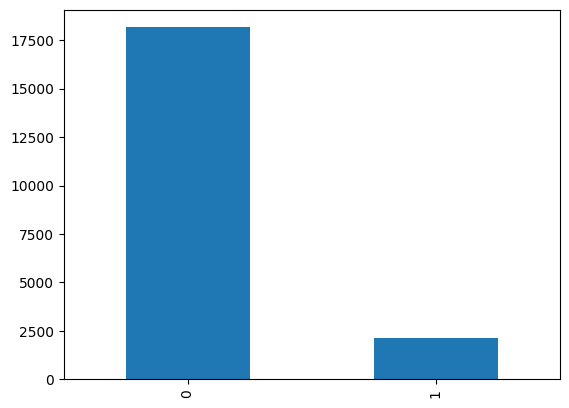

In [7]:
# Plotting

for i in range(3):
    seq = data.sequence.iloc[i]
    trunc_seq = data.truncated_sequence.iloc[i]
    input_ids = input_ids_tensor[i]
    print(f"Original: {len(seq)}, Truncated: {len(trunc_seq)}, Tokenized (no pad): {(input_ids != tokenizer.pad_token_id).sum().item()}")

print("\n")
for key, value in cache_data.items():
    if isinstance(value, torch.Tensor):
        print(f"{key:25s}: Tensor shape {tuple(value.shape)}")
    elif isinstance(value, pd.Series):
        print(f"{key:25s}: pandas Series, length {len(value)}")
    elif isinstance(value, (list, tuple)):
        print(f"{key:25s}: list length {len(value)}")
    else:
        print(f"{key:25s}: type {type(value)}")

data["label"].value_counts().reset_index(drop="True").plot(kind='bar')

# Create DataLoaders

In [8]:
# ATTENTION: the name of the cols in the df must be speicifc
train_indices = [i for i, s in enumerate(cache_data["set"]) if s == "train"] # select indices
train_cache_data = my_dataset.subset_data_dict(cache_data, train_indices) # create cache_data subset
train_dl = my_dataset.create_dataloader(train_cache_data, config["BATCH_SIZE"], shuffle=True) # create dataloader

valid_indices = [i for i, s in enumerate(cache_data["set"]) if s == "val"] 
valid_cache_data = my_dataset.subset_data_dict(cache_data, valid_indices) 
valid_dl = my_dataset.create_dataloader(valid_cache_data, config["BATCH_SIZE"], shuffle=True) 

test_indices = [i for i, s in enumerate(cache_data["set"]) if s == "test"] 
test_cache_data = my_dataset.subset_data_dict(cache_data, test_indices) 
test_dl = my_dataset.create_dataloader(test_cache_data, config["BATCH_SIZE"], shuffle=True) 



# little check:
batch = next(iter(train_dl))

input_ids = batch["input_ids"]
attention_mask = batch["attention_mask"]
labels = batch["label"]
names = batch["name"]
embs = batch["embs"]

print("=== Batch Information ===")
print(f"Batch size: {labels.shape[0]}\n")
print(f"Input IDs: Tensor, shape = {tuple(input_ids.shape)}, dtype = {input_ids.dtype}")
print(f"Attention mask: Tensor, shape = {tuple(attention_mask.shape)}, dtype = {attention_mask.dtype}")
print(f"Labels: Tensor, shape = {tuple(labels.shape)}, dtype = {labels.dtype}")
print(f"First 5 labels: {labels[:5]}")
print(f"Names: List, length = {len(names)}, first 5 = {names[:5]}")
print(f"Embeddings: Tensor, shape = {tuple(embs.shape)}, dtype = {embs.dtype}")


=== Batch Information ===
Batch size: 128

Input IDs: Tensor, shape = (128, 1000), dtype = torch.int64
Attention mask: Tensor, shape = (128, 1000), dtype = torch.int64
Labels: Tensor, shape = (128,), dtype = torch.int64
First 5 labels: tensor([0, 0, 0, 0, 0])
Names: List, length = 128, first 5 = ['Q12882', 'Q9Y3M2', 'P15812', 'P52655', 'P14151']
Embeddings: Tensor, shape = (128, 2560), dtype = torch.float32


# Define weighted loss fucntion

In [9]:
# Get training data
train_data = data[data.set == "train"].copy()

# Count samples per class using value_counts (this gives you a Series with label as index)
class_counts_series = train_data["label"].value_counts().sort_index()

print("Class counts from training data:")
print(class_counts_series)

# Create a tensor for all classes (0 to num_classes-1)
class_counts = torch.zeros(num_classes, dtype=torch.float32)

# Fill in the counts for classes that exist in training data
for label, count in class_counts_series.items():
    class_counts[label] = count

print(f"\nClass counts tensor (aligned by index): {class_counts}")
print(f"Class distribution: {class_counts / class_counts.sum() * 100}%")

# Calculate weights (inverse frequency)
# Add epsilon to avoid division by zero for missing classes
epsilon = 1e-6
class_weights = 1.0 / (class_counts + epsilon)

# Normalize so weights sum to 1
class_weights = class_weights / class_weights.sum()

print(f"\nClass weights (sum={class_weights.sum():.4f}): {class_weights}")

# Verify the alignment
print("\nVerification:")
for i in range(num_classes):
    print(f"  Class {i}: count={class_counts[i]:.0f}, weight={class_weights[i]:.4f}")

# Create loss function
loss_fn = nn.CrossEntropyLoss(weight=class_weights.to(config["DEVICE"]))
#loss_fn = nn.CrossEntropyLoss(weight=torch.tensor([0.001, 0.999]).to(config["DEVICE"]))

Class counts from training data:
label
0    14514
1     1701
Name: count, dtype: int64

Class counts tensor (aligned by index): tensor([14514.,  1701.])
Class distribution: tensor([89.5097, 10.4903])%

Class weights (sum=1.0000): tensor([0.1049, 0.8951])

Verification:
  Class 0: count=14514, weight=0.1049
  Class 1: count=1701, weight=0.8951


# Instantiate Full model

In [10]:
# initialise model (ESM+ HEad)
net = my_models.EsmDeepSec(esm_model, 
                           type_head=config["TYPE_HEAD"],
                           type_emb_for_classification=config["TYPE_EMB_FOR_CLASSIFICATION"],
                           from_precomputed_embs=config["FROM_PRECOMPUTED_EMBS"],
                           precomputed_embs_dim=config["PRECOMPUTED_EMBS_DIM"],
                           num_classes=num_classes,
                           loss_fn=loss_fn,
                           ).to(config["DEVICE"])

print(net.loss_fn.weight)
# hidden dim of final embeggin of each aa after trnafoerm 
print(net.class_head)

# Block ESM paramters to be trained
if net.esm_model is not None:
    print("\nESM hidden dim", net.ESM_hidden_dim, "\n")
    for param in net.esm_model.parameters():
        param.requires_grad = False

tensor([0.1049, 0.8951], device='cuda:0')
MLPHead(
  (layer1): Sequential(
    (0): Linear(in_features=2560, out_features=1280, bias=True)
    (1): LayerNorm((1280,), eps=1e-05, elementwise_affine=True)
    (2): ReLU()
    (3): Dropout(p=0.5, inplace=False)
  )
  (layer2): Sequential(
    (0): Linear(in_features=1280, out_features=628, bias=True)
    (1): LayerNorm((628,), eps=1e-05, elementwise_affine=True)
    (2): ReLU()
    (3): Dropout(p=0.5, inplace=False)
  )
  (layer3): Sequential(
    (0): Linear(in_features=628, out_features=32, bias=True)
    (1): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
    (2): ReLU()
  )
  (classifier): Linear(in_features=32, out_features=2, bias=True)
)

ESM hidden dim 2560 



In [11]:
# Save config
with open(os.path.join(config["RESULTS_FOLDER_PATH"], "config.json"), 'w') as f:
    json.dump(config, f, indent=4)

# Train

In [12]:
#results = mf.train(net, train_dl, valid_dl, test_dl, loss_fn, config)
results = mf.train(net, train_dl, valid_dl, test_dl, loss_fn, config, from_precomputed_embs=config["FROM_PRECOMPUTED_EMBS"]) # precomputed are in the dataloder

# save reuslts
serializable_results = mf.tensor_to_python(results)
with open(os.path.join(config["RESULTS_FOLDER_PATH"], "result_train_test.json"), 'w') as f:
    json.dump(serializable_results, f, indent=4)

clear_output(wait=True)

Training:   0%|          | 0/100 [00:00<?, ?epoch/s]

Epoch 1:   0%|          | 0/127 [00:00<?, ?train batch/s]

Epoch 2:   0%|          | 0/127 [00:00<?, ?train batch/s]

Epoch 3:   0%|          | 0/127 [00:00<?, ?train batch/s]

Epoch 4:   0%|          | 0/127 [00:00<?, ?train batch/s]

Epoch 5:   0%|          | 0/127 [00:00<?, ?train batch/s]

--- Evaluation at iteration 5 ---


Evaluation:   0%|          | 0/127 [00:00<?, ? Train batch/s]

	Train set: Loss: 0.2579, Acc: 89.80%, Balanced Acc: 91.53%, F1: 0.9105, MCC: 0.6439, AUC: 0.9630


Evaluation:   0%|          | 0/1 [00:00<?, ? Validation batch/s]

	Validation set: Loss: 0.0615, Acc: 100.00%, Balanced Acc: 100.00%, F1: 1.0000, MCC: 0.0000, AUC: nan


/home/gdallagl/.pyenv/versions/esm2_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:534: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/home/gdallagl/.pyenv/versions/esm2_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:534: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/home/gdallagl/.pyenv/versions/esm2_env/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


Evaluation:   0%|          | 0/32 [00:00<?, ? Test batch/s]

	Test set: Loss: 0.2969, Acc: 88.63%, Balanced Acc: 89.89%, F1: 0.9010, MCC: 0.6091, AUC: 0.9536


Epoch 6:   0%|          | 0/127 [00:00<?, ?train batch/s]

Epoch 7:   0%|          | 0/127 [00:00<?, ?train batch/s]

Epoch 8:   0%|          | 0/127 [00:00<?, ?train batch/s]

Epoch 9:   0%|          | 0/127 [00:00<?, ?train batch/s]

Epoch 10:   0%|          | 0/127 [00:00<?, ?train batch/s]

--- Evaluation at iteration 10 ---


Evaluation:   0%|          | 0/127 [00:00<?, ? Train batch/s]

	Train set: Loss: 0.2266, Acc: 89.88%, Balanced Acc: 91.88%, F1: 0.9113, MCC: 0.6486, AUC: 0.9713


Evaluation:   0%|          | 0/1 [00:00<?, ? Validation batch/s]

	Validation set: Loss: 0.0967, Acc: 100.00%, Balanced Acc: 100.00%, F1: 1.0000, MCC: 0.0000, AUC: nan


/home/gdallagl/.pyenv/versions/esm2_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:534: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/home/gdallagl/.pyenv/versions/esm2_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:534: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/home/gdallagl/.pyenv/versions/esm2_env/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


Evaluation:   0%|          | 0/32 [00:00<?, ? Test batch/s]

	Test set: Loss: 0.2725, Acc: 88.66%, Balanced Acc: 90.22%, F1: 0.9014, MCC: 0.6127, AUC: 0.9591


Epoch 11:   0%|          | 0/127 [00:00<?, ?train batch/s]

Epoch 12:   0%|          | 0/127 [00:00<?, ?train batch/s]

Epoch 13:   0%|          | 0/127 [00:00<?, ?train batch/s]

Epoch 14:   0%|          | 0/127 [00:00<?, ?train batch/s]

Epoch 15:   0%|          | 0/127 [00:00<?, ?train batch/s]

--- Evaluation at iteration 15 ---


Evaluation:   0%|          | 0/127 [00:00<?, ? Train batch/s]

	Train set: Loss: 0.2214, Acc: 89.16%, Balanced Acc: 92.26%, F1: 0.9060, MCC: 0.6413, AUC: 0.9763


Evaluation:   0%|          | 0/1 [00:00<?, ? Validation batch/s]

	Validation set: Loss: 0.0673, Acc: 100.00%, Balanced Acc: 100.00%, F1: 1.0000, MCC: 0.0000, AUC: nan


/home/gdallagl/.pyenv/versions/esm2_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:534: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/home/gdallagl/.pyenv/versions/esm2_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:534: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/home/gdallagl/.pyenv/versions/esm2_env/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


Evaluation:   0%|          | 0/32 [00:00<?, ? Test batch/s]

	Test set: Loss: 0.2806, Acc: 87.52%, Balanced Acc: 90.22%, F1: 0.8929, MCC: 0.5973, AUC: 0.9608


Epoch 16:   0%|          | 0/127 [00:00<?, ?train batch/s]

Epoch 17:   0%|          | 0/127 [00:00<?, ?train batch/s]

Epoch 18:   0%|          | 0/127 [00:00<?, ?train batch/s]

Epoch 19:   0%|          | 0/127 [00:00<?, ?train batch/s]

Epoch 20:   0%|          | 0/127 [00:00<?, ?train batch/s]

--- Evaluation at iteration 20 ---


Evaluation:   0%|          | 0/127 [00:00<?, ? Train batch/s]

	Train set: Loss: 0.2325, Acc: 87.70%, Balanced Acc: 91.96%, F1: 0.8947, MCC: 0.6184, AUC: 0.9784


Evaluation:   0%|          | 0/1 [00:00<?, ? Validation batch/s]

	Validation set: Loss: 0.0584, Acc: 100.00%, Balanced Acc: 100.00%, F1: 1.0000, MCC: 0.0000, AUC: nan


/home/gdallagl/.pyenv/versions/esm2_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:534: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/home/gdallagl/.pyenv/versions/esm2_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:534: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/home/gdallagl/.pyenv/versions/esm2_env/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


Evaluation:   0%|          | 0/32 [00:00<?, ? Test batch/s]

	Test set: Loss: 0.2958, Acc: 85.75%, Balanced Acc: 89.65%, F1: 0.8794, MCC: 0.5709, AUC: 0.9613


Epoch 21:   0%|          | 0/127 [00:00<?, ?train batch/s]

Epoch 22:   0%|          | 0/127 [00:00<?, ?train batch/s]

Epoch 23:   0%|          | 0/127 [00:00<?, ?train batch/s]

Epoch 24:   0%|          | 0/127 [00:00<?, ?train batch/s]

Epoch 25:   0%|          | 0/127 [00:00<?, ?train batch/s]

--- Evaluation at iteration 25 ---


Evaluation:   0%|          | 0/127 [00:00<?, ? Train batch/s]

	Train set: Loss: 0.1664, Acc: 92.67%, Balanced Acc: 94.11%, F1: 0.9339, MCC: 0.7202, AUC: 0.9812


Evaluation:   0%|          | 0/1 [00:00<?, ? Validation batch/s]

	Validation set: Loss: 0.1823, Acc: 100.00%, Balanced Acc: 100.00%, F1: 1.0000, MCC: 0.0000, AUC: nan


/home/gdallagl/.pyenv/versions/esm2_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:534: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/home/gdallagl/.pyenv/versions/esm2_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:534: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/home/gdallagl/.pyenv/versions/esm2_env/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


Evaluation:   0%|          | 0/32 [00:00<?, ? Test batch/s]

	Test set: Loss: 0.2484, Acc: 91.12%, Balanced Acc: 91.39%, F1: 0.9207, MCC: 0.6642, AUC: 0.9611


Epoch 26:   0%|          | 0/127 [00:00<?, ?train batch/s]

Epoch 27:   0%|          | 0/127 [00:00<?, ?train batch/s]

Epoch 28:   0%|          | 0/127 [00:00<?, ?train batch/s]

Epoch 29:   0%|          | 0/127 [00:00<?, ?train batch/s]

Epoch 30:   0%|          | 0/127 [00:00<?, ?train batch/s]

--- Evaluation at iteration 30 ---


Evaluation:   0%|          | 0/127 [00:00<?, ? Train batch/s]

	Train set: Loss: 0.1772, Acc: 90.88%, Balanced Acc: 93.84%, F1: 0.9198, MCC: 0.6834, AUC: 0.9817


Evaluation:   0%|          | 0/1 [00:00<?, ? Validation batch/s]

	Validation set: Loss: 0.0855, Acc: 100.00%, Balanced Acc: 100.00%, F1: 1.0000, MCC: 0.0000, AUC: nan


/home/gdallagl/.pyenv/versions/esm2_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:534: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/home/gdallagl/.pyenv/versions/esm2_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:534: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/home/gdallagl/.pyenv/versions/esm2_env/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


Evaluation:   0%|          | 0/32 [00:00<?, ? Test batch/s]

	Test set: Loss: 0.2614, Acc: 88.88%, Balanced Acc: 90.55%, F1: 0.9032, MCC: 0.6191, AUC: 0.9590


Epoch 31:   0%|          | 0/127 [00:00<?, ?train batch/s]

Epoch 32:   0%|          | 0/127 [00:00<?, ?train batch/s]

Epoch 33:   0%|          | 0/127 [00:00<?, ?train batch/s]

Epoch 34:   0%|          | 0/127 [00:00<?, ?train batch/s]

Epoch 35:   0%|          | 0/127 [00:00<?, ?train batch/s]

--- Evaluation at iteration 35 ---


Evaluation:   0%|          | 0/127 [00:00<?, ? Train batch/s]

	Train set: Loss: 0.1461, Acc: 93.77%, Balanced Acc: 95.17%, F1: 0.9432, MCC: 0.7535, AUC: 0.9841


Evaluation:   0%|          | 0/1 [00:00<?, ? Validation batch/s]

	Validation set: Loss: 0.1086, Acc: 100.00%, Balanced Acc: 100.00%, F1: 1.0000, MCC: 0.0000, AUC: nan


/home/gdallagl/.pyenv/versions/esm2_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:534: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/home/gdallagl/.pyenv/versions/esm2_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:534: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/home/gdallagl/.pyenv/versions/esm2_env/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


Evaluation:   0%|          | 0/32 [00:00<?, ? Test batch/s]

	Test set: Loss: 0.2580, Acc: 92.32%, Balanced Acc: 91.43%, F1: 0.9302, MCC: 0.6890, AUC: 0.9556


Epoch 36:   0%|          | 0/127 [00:00<?, ?train batch/s]

Epoch 37:   0%|          | 0/127 [00:00<?, ?train batch/s]

Epoch 38:   0%|          | 0/127 [00:00<?, ?train batch/s]

Epoch 39:   0%|          | 0/127 [00:00<?, ?train batch/s]

Epoch 40:   0%|          | 0/127 [00:00<?, ?train batch/s]

--- Evaluation at iteration 40 ---


Evaluation:   0%|          | 0/127 [00:00<?, ? Train batch/s]

	Train set: Loss: 0.1484, Acc: 92.23%, Balanced Acc: 94.88%, F1: 0.9307, MCC: 0.7176, AUC: 0.9857


Evaluation:   0%|          | 0/1 [00:00<?, ? Validation batch/s]

	Validation set: Loss: 0.1613, Acc: 100.00%, Balanced Acc: 100.00%, F1: 1.0000, MCC: 0.0000, AUC: nan


/home/gdallagl/.pyenv/versions/esm2_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:534: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/home/gdallagl/.pyenv/versions/esm2_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:534: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/home/gdallagl/.pyenv/versions/esm2_env/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


Evaluation:   0%|          | 0/32 [00:00<?, ? Test batch/s]

	Test set: Loss: 0.2601, Acc: 90.18%, Balanced Acc: 91.18%, F1: 0.9134, MCC: 0.6456, AUC: 0.9572


Epoch 41:   0%|          | 0/127 [00:00<?, ?train batch/s]

Epoch 42:   0%|          | 0/127 [00:00<?, ?train batch/s]

Epoch 43:   0%|          | 0/127 [00:00<?, ?train batch/s]

Epoch 44:   0%|          | 0/127 [00:00<?, ?train batch/s]

Epoch 45:   0%|          | 0/127 [00:00<?, ?train batch/s]

--- Evaluation at iteration 45 ---


Evaluation:   0%|          | 0/127 [00:00<?, ? Train batch/s]

	Train set: Loss: 0.1301, Acc: 95.87%, Balanced Acc: 95.72%, F1: 0.9610, MCC: 0.8153, AUC: 0.9874


Evaluation:   0%|          | 0/1 [00:00<?, ? Validation batch/s]

	Validation set: Loss: 0.2587, Acc: 100.00%, Balanced Acc: 100.00%, F1: 1.0000, MCC: 0.0000, AUC: nan


/home/gdallagl/.pyenv/versions/esm2_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:534: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/home/gdallagl/.pyenv/versions/esm2_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:534: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/home/gdallagl/.pyenv/versions/esm2_env/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


Evaluation:   0%|          | 0/32 [00:00<?, ? Test batch/s]

	Test set: Loss: 0.2893, Acc: 94.22%, Balanced Acc: 90.61%, F1: 0.9452, MCC: 0.7307, AUC: 0.9538


Epoch 46:   0%|          | 0/127 [00:00<?, ?train batch/s]

Epoch 47:   0%|          | 0/127 [00:00<?, ?train batch/s]

Epoch 48:   0%|          | 0/127 [00:00<?, ?train batch/s]

Epoch 49:   0%|          | 0/127 [00:00<?, ?train batch/s]

Epoch 50:   0%|          | 0/127 [00:00<?, ?train batch/s]

--- Evaluation at iteration 50 ---


Evaluation:   0%|          | 0/127 [00:00<?, ? Train batch/s]

	Train set: Loss: 0.1170, Acc: 95.26%, Balanced Acc: 96.29%, F1: 0.9560, MCC: 0.8007, AUC: 0.9886


Evaluation:   0%|          | 0/1 [00:00<?, ? Validation batch/s]

	Validation set: Loss: 0.1928, Acc: 100.00%, Balanced Acc: 100.00%, F1: 1.0000, MCC: 0.0000, AUC: nan


/home/gdallagl/.pyenv/versions/esm2_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:534: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/home/gdallagl/.pyenv/versions/esm2_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:534: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/home/gdallagl/.pyenv/versions/esm2_env/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


Evaluation:   0%|          | 0/32 [00:00<?, ? Test batch/s]

	Test set: Loss: 0.2848, Acc: 93.11%, Balanced Acc: 91.14%, F1: 0.9364, MCC: 0.7049, AUC: 0.9559


Epoch 51:   0%|          | 0/127 [00:00<?, ?train batch/s]

Epoch 52:   0%|          | 0/127 [00:00<?, ?train batch/s]

Epoch 53:   0%|          | 0/127 [00:00<?, ?train batch/s]

Epoch 54:   0%|          | 0/127 [00:00<?, ?train batch/s]

Epoch 55:   0%|          | 0/127 [00:00<?, ?train batch/s]

--- Evaluation at iteration 55 ---


Evaluation:   0%|          | 0/127 [00:00<?, ? Train batch/s]

	Train set: Loss: 0.1147, Acc: 96.59%, Balanced Acc: 96.28%, F1: 0.9675, MCC: 0.8423, AUC: 0.9899


Evaluation:   0%|          | 0/1 [00:00<?, ? Validation batch/s]

	Validation set: Loss: 0.5089, Acc: 100.00%, Balanced Acc: 100.00%, F1: 1.0000, MCC: 0.0000, AUC: nan


/home/gdallagl/.pyenv/versions/esm2_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:534: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/home/gdallagl/.pyenv/versions/esm2_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:534: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/home/gdallagl/.pyenv/versions/esm2_env/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


Evaluation:   0%|          | 0/32 [00:00<?, ? Test batch/s]

	Test set: Loss: 0.3089, Acc: 94.81%, Balanced Acc: 90.31%, F1: 0.9501, MCC: 0.7470, AUC: 0.9545


Epoch 56:   0%|          | 0/127 [00:00<?, ?train batch/s]

Epoch 57:   0%|          | 0/127 [00:00<?, ?train batch/s]

Epoch 58:   0%|          | 0/127 [00:00<?, ?train batch/s]

Epoch 59:   0%|          | 0/127 [00:00<?, ?train batch/s]

Epoch 60:   0%|          | 0/127 [00:00<?, ?train batch/s]

--- Evaluation at iteration 60 ---


Evaluation:   0%|          | 0/127 [00:00<?, ? Train batch/s]

	Train set: Loss: 0.1007, Acc: 95.44%, Balanced Acc: 96.78%, F1: 0.9576, MCC: 0.8088, AUC: 0.9908


Evaluation:   0%|          | 0/1 [00:00<?, ? Validation batch/s]

	Validation set: Loss: 0.1744, Acc: 100.00%, Balanced Acc: 100.00%, F1: 1.0000, MCC: 0.0000, AUC: nan


/home/gdallagl/.pyenv/versions/esm2_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:534: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/home/gdallagl/.pyenv/versions/esm2_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:534: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/home/gdallagl/.pyenv/versions/esm2_env/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


Evaluation:   0%|          | 0/32 [00:00<?, ? Test batch/s]

	Test set: Loss: 0.3001, Acc: 93.23%, Balanced Acc: 91.31%, F1: 0.9374, MCC: 0.7093, AUC: 0.9551


Epoch 61:   0%|          | 0/127 [00:00<?, ?train batch/s]

Epoch 62:   0%|          | 0/127 [00:00<?, ?train batch/s]

Epoch 63:   0%|          | 0/127 [00:00<?, ?train batch/s]

Epoch 64:   0%|          | 0/127 [00:00<?, ?train batch/s]

Epoch 65:   0%|          | 0/127 [00:00<?, ?train batch/s]

--- Evaluation at iteration 65 ---


Evaluation:   0%|          | 0/127 [00:00<?, ? Train batch/s]

	Train set: Loss: 0.0968, Acc: 95.71%, Balanced Acc: 97.06%, F1: 0.9601, MCC: 0.8187, AUC: 0.9916


Evaluation:   0%|          | 0/1 [00:00<?, ? Validation batch/s]

	Validation set: Loss: 0.2687, Acc: 100.00%, Balanced Acc: 100.00%, F1: 1.0000, MCC: 0.0000, AUC: nan


/home/gdallagl/.pyenv/versions/esm2_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:534: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/home/gdallagl/.pyenv/versions/esm2_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:534: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/home/gdallagl/.pyenv/versions/esm2_env/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


Evaluation:   0%|          | 0/32 [00:00<?, ? Test batch/s]

	Test set: Loss: 0.2938, Acc: 93.45%, Balanced Acc: 91.33%, F1: 0.9392, MCC: 0.7151, AUC: 0.9556


Epoch 66:   0%|          | 0/127 [00:00<?, ?train batch/s]

Epoch 67:   0%|          | 0/127 [00:00<?, ?train batch/s]

Epoch 68:   0%|          | 0/127 [00:00<?, ?train batch/s]

Epoch 69:   0%|          | 0/127 [00:00<?, ?train batch/s]

Epoch 70:   0%|          | 0/127 [00:00<?, ?train batch/s]

--- Evaluation at iteration 70 ---


Evaluation:   0%|          | 0/127 [00:00<?, ? Train batch/s]

	Train set: Loss: 0.0847, Acc: 96.84%, Balanced Acc: 97.48%, F1: 0.9700, MCC: 0.8572, AUC: 0.9922


Evaluation:   0%|          | 0/1 [00:00<?, ? Validation batch/s]

	Validation set: Loss: 0.2895, Acc: 100.00%, Balanced Acc: 100.00%, F1: 1.0000, MCC: 0.0000, AUC: nan


/home/gdallagl/.pyenv/versions/esm2_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:534: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/home/gdallagl/.pyenv/versions/esm2_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:534: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/home/gdallagl/.pyenv/versions/esm2_env/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


Evaluation:   0%|          | 0/32 [00:00<?, ? Test batch/s]

	Test set: Loss: 0.3403, Acc: 94.69%, Balanced Acc: 90.14%, F1: 0.9489, MCC: 0.7419, AUC: 0.9361


Epoch 71:   0%|          | 0/127 [00:00<?, ?train batch/s]

Epoch 72:   0%|          | 0/127 [00:00<?, ?train batch/s]

Epoch 73:   0%|          | 0/127 [00:00<?, ?train batch/s]

Epoch 74:   0%|          | 0/127 [00:00<?, ?train batch/s]

Epoch 75:   0%|          | 0/127 [00:00<?, ?train batch/s]

--- Evaluation at iteration 75 ---


Evaluation:   0%|          | 0/127 [00:00<?, ? Train batch/s]

	Train set: Loss: 0.0962, Acc: 95.12%, Balanced Acc: 96.93%, F1: 0.9550, MCC: 0.8009, AUC: 0.9926


Evaluation:   0%|          | 0/1 [00:00<?, ? Validation batch/s]

	Validation set: Loss: 0.1333, Acc: 100.00%, Balanced Acc: 100.00%, F1: 1.0000, MCC: 0.0000, AUC: nan


/home/gdallagl/.pyenv/versions/esm2_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:534: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/home/gdallagl/.pyenv/versions/esm2_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:534: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/home/gdallagl/.pyenv/versions/esm2_env/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


Evaluation:   0%|          | 0/32 [00:00<?, ? Test batch/s]

	Test set: Loss: 0.3114, Acc: 92.54%, Balanced Acc: 91.35%, F1: 0.9319, MCC: 0.6933, AUC: 0.9480


Epoch 76:   0%|          | 0/127 [00:00<?, ?train batch/s]

Epoch 77:   0%|          | 0/127 [00:00<?, ?train batch/s]

Epoch 78:   0%|          | 0/127 [00:00<?, ?train batch/s]

Epoch 79:   0%|          | 0/127 [00:00<?, ?train batch/s]

Epoch 80:   0%|          | 0/127 [00:00<?, ?train batch/s]

--- Evaluation at iteration 80 ---


Evaluation:   0%|          | 0/127 [00:00<?, ? Train batch/s]

	Train set: Loss: 0.0804, Acc: 96.83%, Balanced Acc: 97.76%, F1: 0.9700, MCC: 0.8582, AUC: 0.9931


Evaluation:   0%|          | 0/1 [00:00<?, ? Validation batch/s]

	Validation set: Loss: 0.1374, Acc: 100.00%, Balanced Acc: 100.00%, F1: 1.0000, MCC: 0.0000, AUC: nan


/home/gdallagl/.pyenv/versions/esm2_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:534: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/home/gdallagl/.pyenv/versions/esm2_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:534: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/home/gdallagl/.pyenv/versions/esm2_env/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


Evaluation:   0%|          | 0/32 [00:00<?, ? Test batch/s]

	Test set: Loss: 0.3407, Acc: 94.61%, Balanced Acc: 91.14%, F1: 0.9487, MCC: 0.7462, AUC: 0.9369


Epoch 81:   0%|          | 0/127 [00:00<?, ?train batch/s]

Epoch 82:   0%|          | 0/127 [00:00<?, ?train batch/s]

Epoch 83:   0%|          | 0/127 [00:00<?, ?train batch/s]

Epoch 84:   0%|          | 0/127 [00:00<?, ?train batch/s]

Epoch 85:   0%|          | 0/127 [00:00<?, ?train batch/s]

--- Evaluation at iteration 85 ---


Evaluation:   0%|          | 0/127 [00:00<?, ? Train batch/s]

	Train set: Loss: 0.0843, Acc: 96.37%, Balanced Acc: 97.61%, F1: 0.9659, MCC: 0.8423, AUC: 0.9936


Evaluation:   0%|          | 0/1 [00:00<?, ? Validation batch/s]

	Validation set: Loss: 0.1387, Acc: 100.00%, Balanced Acc: 100.00%, F1: 1.0000, MCC: 0.0000, AUC: nan


/home/gdallagl/.pyenv/versions/esm2_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:534: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/home/gdallagl/.pyenv/versions/esm2_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:534: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/home/gdallagl/.pyenv/versions/esm2_env/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


Evaluation:   0%|          | 0/32 [00:00<?, ? Test batch/s]

	Test set: Loss: 0.3397, Acc: 94.02%, Balanced Acc: 91.33%, F1: 0.9439, MCC: 0.7302, AUC: 0.9353


Epoch 86:   0%|          | 0/127 [00:00<?, ?train batch/s]

Epoch 87:   0%|          | 0/127 [00:00<?, ?train batch/s]

Epoch 88:   0%|          | 0/127 [00:00<?, ?train batch/s]

Epoch 89:   0%|          | 0/127 [00:00<?, ?train batch/s]

Epoch 90:   0%|          | 0/127 [00:00<?, ?train batch/s]

--- Evaluation at iteration 90 ---


Evaluation:   0%|          | 0/127 [00:00<?, ? Train batch/s]

	Train set: Loss: 0.0710, Acc: 97.64%, Balanced Acc: 98.06%, F1: 0.9773, MCC: 0.8888, AUC: 0.9942


Evaluation:   0%|          | 0/1 [00:00<?, ? Validation batch/s]

	Validation set: Loss: 0.5352, Acc: 100.00%, Balanced Acc: 100.00%, F1: 1.0000, MCC: 0.0000, AUC: nan


/home/gdallagl/.pyenv/versions/esm2_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:534: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/home/gdallagl/.pyenv/versions/esm2_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:534: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/home/gdallagl/.pyenv/versions/esm2_env/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


Evaluation:   0%|          | 0/32 [00:00<?, ? Test batch/s]

	Test set: Loss: 0.3852, Acc: 94.78%, Balanced Acc: 89.25%, F1: 0.9494, MCC: 0.7395, AUC: 0.9315


Epoch 91:   0%|          | 0/127 [00:00<?, ?train batch/s]

Epoch 92:   0%|          | 0/127 [00:00<?, ?train batch/s]

Epoch 93:   0%|          | 0/127 [00:00<?, ?train batch/s]

Epoch 94:   0%|          | 0/127 [00:00<?, ?train batch/s]

Epoch 95:   0%|          | 0/127 [00:00<?, ?train batch/s]

--- Evaluation at iteration 95 ---


Evaluation:   0%|          | 0/127 [00:00<?, ? Train batch/s]

	Train set: Loss: 0.0655, Acc: 97.72%, Balanced Acc: 98.26%, F1: 0.9781, MCC: 0.8927, AUC: 0.9945


Evaluation:   0%|          | 0/1 [00:00<?, ? Validation batch/s]

	Validation set: Loss: 0.4065, Acc: 100.00%, Balanced Acc: 100.00%, F1: 1.0000, MCC: 0.0000, AUC: nan


/home/gdallagl/.pyenv/versions/esm2_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:534: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/home/gdallagl/.pyenv/versions/esm2_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:534: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/home/gdallagl/.pyenv/versions/esm2_env/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


Evaluation:   0%|          | 0/32 [00:00<?, ? Test batch/s]

	Test set: Loss: 0.3750, Acc: 95.05%, Balanced Acc: 89.51%, F1: 0.9518, MCC: 0.7504, AUC: 0.9299


Epoch 96:   0%|          | 0/127 [00:00<?, ?train batch/s]

Epoch 97:   0%|          | 0/127 [00:00<?, ?train batch/s]

Epoch 98:   0%|          | 0/127 [00:00<?, ?train batch/s]

Epoch 99:   0%|          | 0/127 [00:00<?, ?train batch/s]

Epoch 100:   0%|          | 0/127 [00:00<?, ?train batch/s]

--- Evaluation at iteration 100 ---


Evaluation:   0%|          | 0/127 [00:00<?, ? Train batch/s]

	Train set: Loss: 0.0689, Acc: 97.39%, Balanced Acc: 98.15%, F1: 0.9750, MCC: 0.8798, AUC: 0.9949


Evaluation:   0%|          | 0/1 [00:00<?, ? Validation batch/s]

	Validation set: Loss: 0.2828, Acc: 100.00%, Balanced Acc: 100.00%, F1: 1.0000, MCC: 0.0000, AUC: nan


/home/gdallagl/.pyenv/versions/esm2_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:534: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/home/gdallagl/.pyenv/versions/esm2_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:534: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/home/gdallagl/.pyenv/versions/esm2_env/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


Evaluation:   0%|          | 0/32 [00:00<?, ? Test batch/s]

	Test set: Loss: 0.3643, Acc: 94.59%, Balanced Acc: 90.29%, F1: 0.9482, MCC: 0.7397, AUC: 0.9367


### Plot


                         FINAL EVALUATION METRICS
Metric                   Train           Test
---------------------------------------------
Loss                    0.0689         0.3643
Accuracy                97.39%         94.59%
Balanced Acc            98.15%         90.29%
F1 Score                0.9750         0.9482
MCC                     0.8798         0.7397
AUC-ROC                 0.9949         0.9367

✅ Figure saved to: /home/gdallagl/myworkdir/ESMSec/data/model_results/secreted_Uniprot-locations_03_dataset_final_sample-neg=False/result_train_test_image.pdf


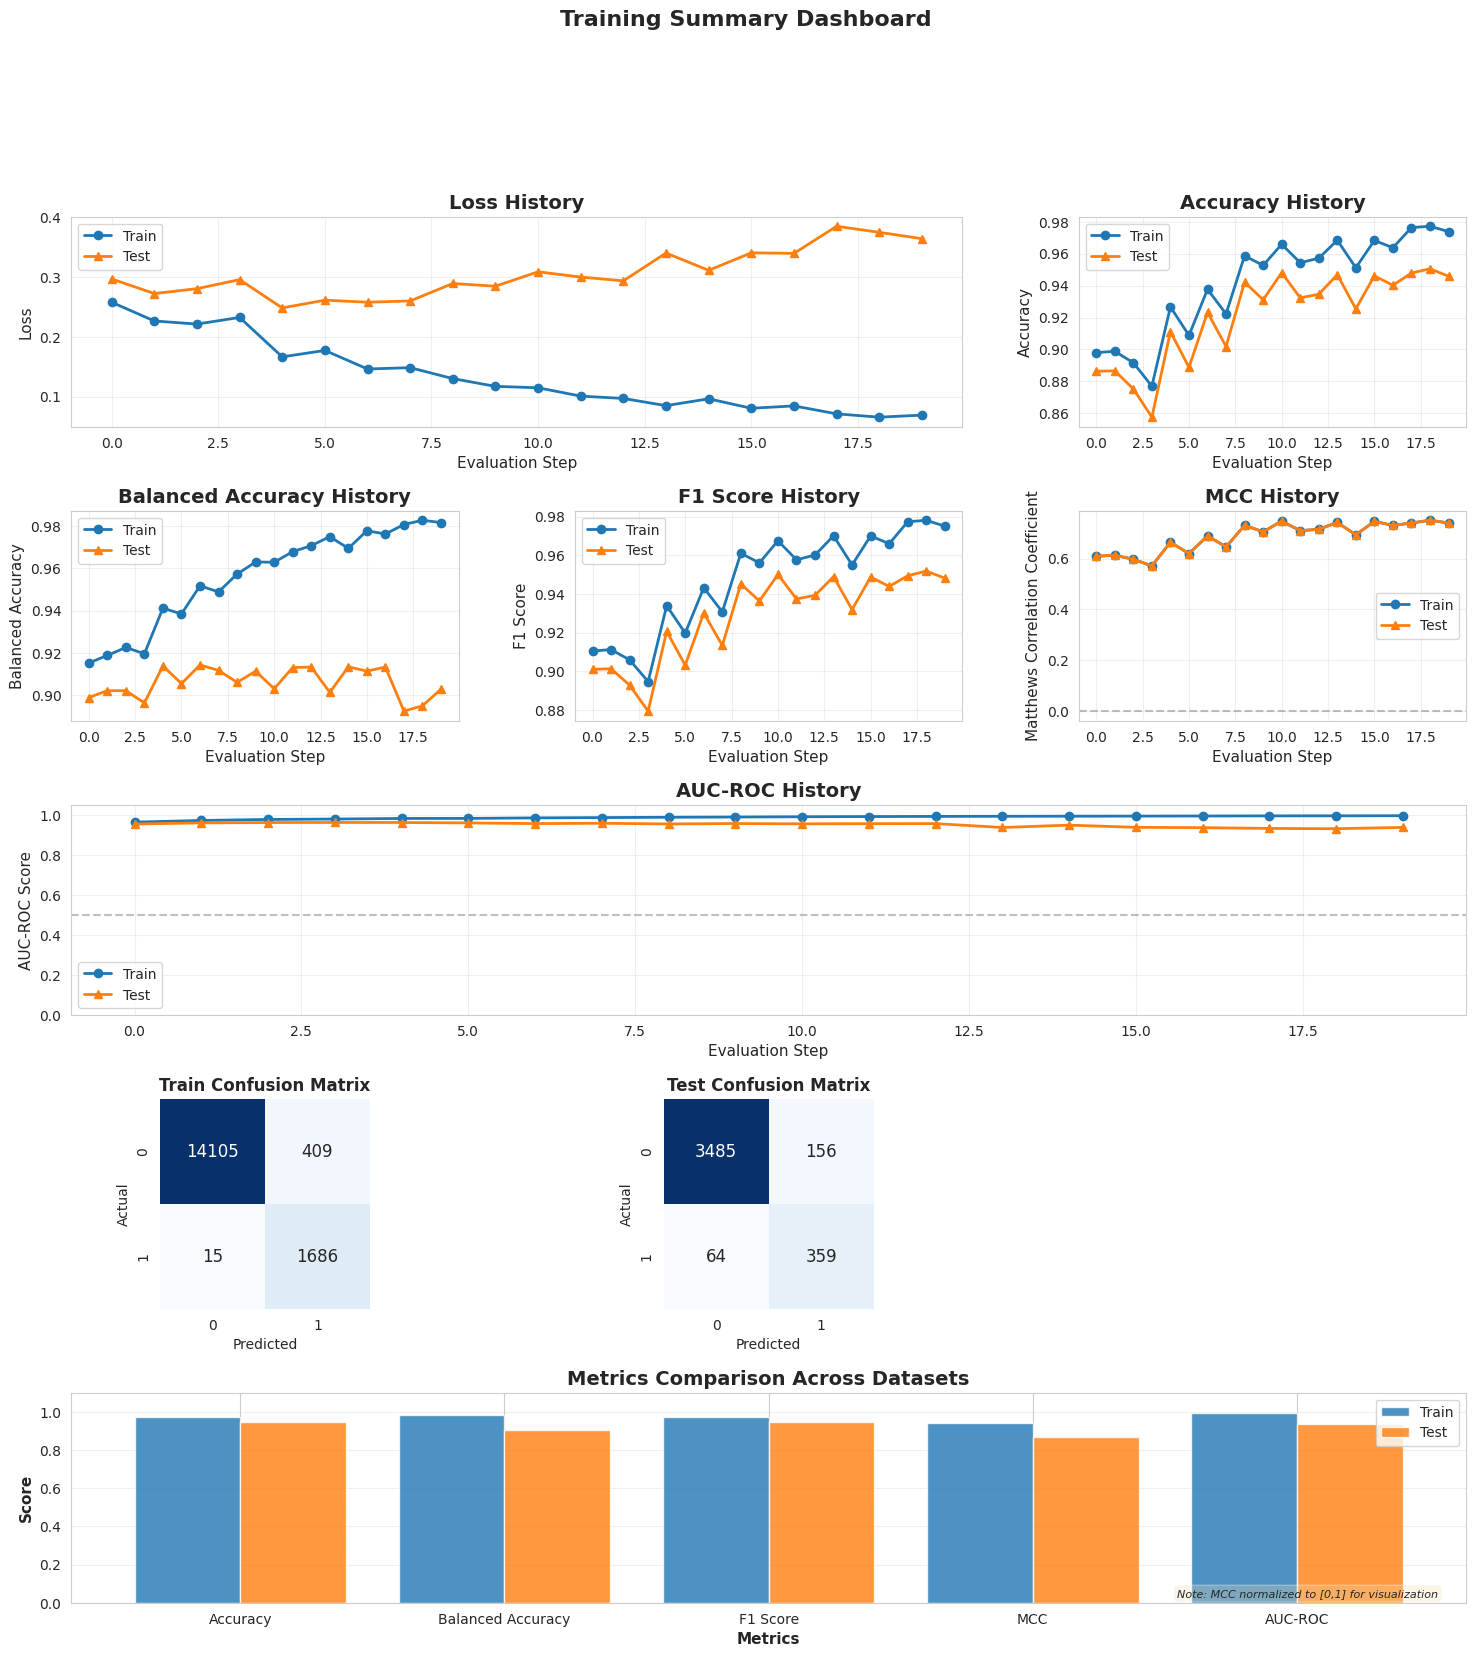


                         TEST SET CLASSIFICATION REPORT
              precision    recall  f1-score   support

     Class 0     0.9820    0.9572    0.9694      3641
     Class 1     0.6971    0.8487    0.7655       423

    accuracy                         0.9459      4064
   macro avg     0.8395    0.9029    0.8674      4064
weighted avg     0.9523    0.9459    0.9482      4064



                         TRAIN SET CLASSIFICATION REPORT
              precision    recall  f1-score   support

     Class 0     0.9989    0.9718    0.9852     14514
     Class 1     0.8048    0.9912    0.8883      1701

    accuracy                         0.9739     16215
   macro avg     0.9019    0.9815    0.9367     16215
weighted avg     0.9786    0.9739    0.9750     16215




In [13]:
fig = mf.summarize_results(results, 
                     num_classes=num_classes, 
                     plot_val=False,
                     save_path=os.path.join(config["RESULTS_FOLDER_PATH"], "result_train_test_image.pdf")
                     )

### Save Model

In [14]:
#torch.save(net, config["PATH_TO_SAVE_MODEL"])

### Load Model

In [15]:
#net = torch.load(config["PATH_TO_SAVE_MODEL"])
net.eval()

EsmDeepSec(
  (esm_model): EsmModel(
    (embeddings): EsmEmbeddings(
      (word_embeddings): Embedding(33, 2560, padding_idx=1)
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): EsmEncoder(
      (layer): ModuleList(
        (0-35): 36 x EsmLayer(
          (attention): EsmAttention(
            (self): EsmSelfAttention(
              (query): Linear(in_features=2560, out_features=2560, bias=True)
              (key): Linear(in_features=2560, out_features=2560, bias=True)
              (value): Linear(in_features=2560, out_features=2560, bias=True)
              (rotary_embeddings): RotaryEmbedding()
            )
            (output): EsmSelfOutput(
              (dense): Linear(in_features=2560, out_features=2560, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (LayerNorm): LayerNorm((2560,), eps=1e-05, elementwise_affine=True)
          )
          (intermediate): EsmIntermediate(
            (dense): Linear(in_features

### Umaps

Many types of embeddings can be extracted from different moments inside the model:

**1. From the ESM backbone**
- **ESM mean** → mean pooling over all token embeddings.  
- **ESM max** → max pooling over all token embeddings.  
- **ESM CLS** → embedding of the special classification token (first position).  
- **ESM tokens** → full sequence of token-level embeddings `[batch, seq_len, hidden_dim]`.  
- (Optional) **Layerwise embeddings** → extracting hidden states from multiple layers (e.g. last 4).

**2. From the feature head (AttentionClassificationHead)**
- **Feature mean** → mean pooling after attention + FFNN.  
- **Feature max** → max pooling after attention + FFNN.  
- **Feature CLS** → CLS token representation after attention + FFNN.  
- **Feature concat** → concatenation of mean and max pooling (used for classification).  


Extracting embeddings from training set...



Batch:   0%|          | 0/127 [00:00<?, ? batch/s]

All possbile embedding given current model architecrure:
class_head_embs_mlp_layer3: (16215, 32)
precomputed_embs: (16215, 2560)

Computing UMAP embeddings...

Computing UMAP for class_head_embs_mlp_layer3 with shape (16215, 32)...
Computing UMAP for precomputed_embs with shape (16215, 2560)...

Plotting UMAP embeddings...


✅ Embedding plot saved to: /home/gdallagl/myworkdir/ESMSec/data/model_results/secreted_Uniprot-locations_03_dataset_final_sample-neg=False/umap_train.pdf


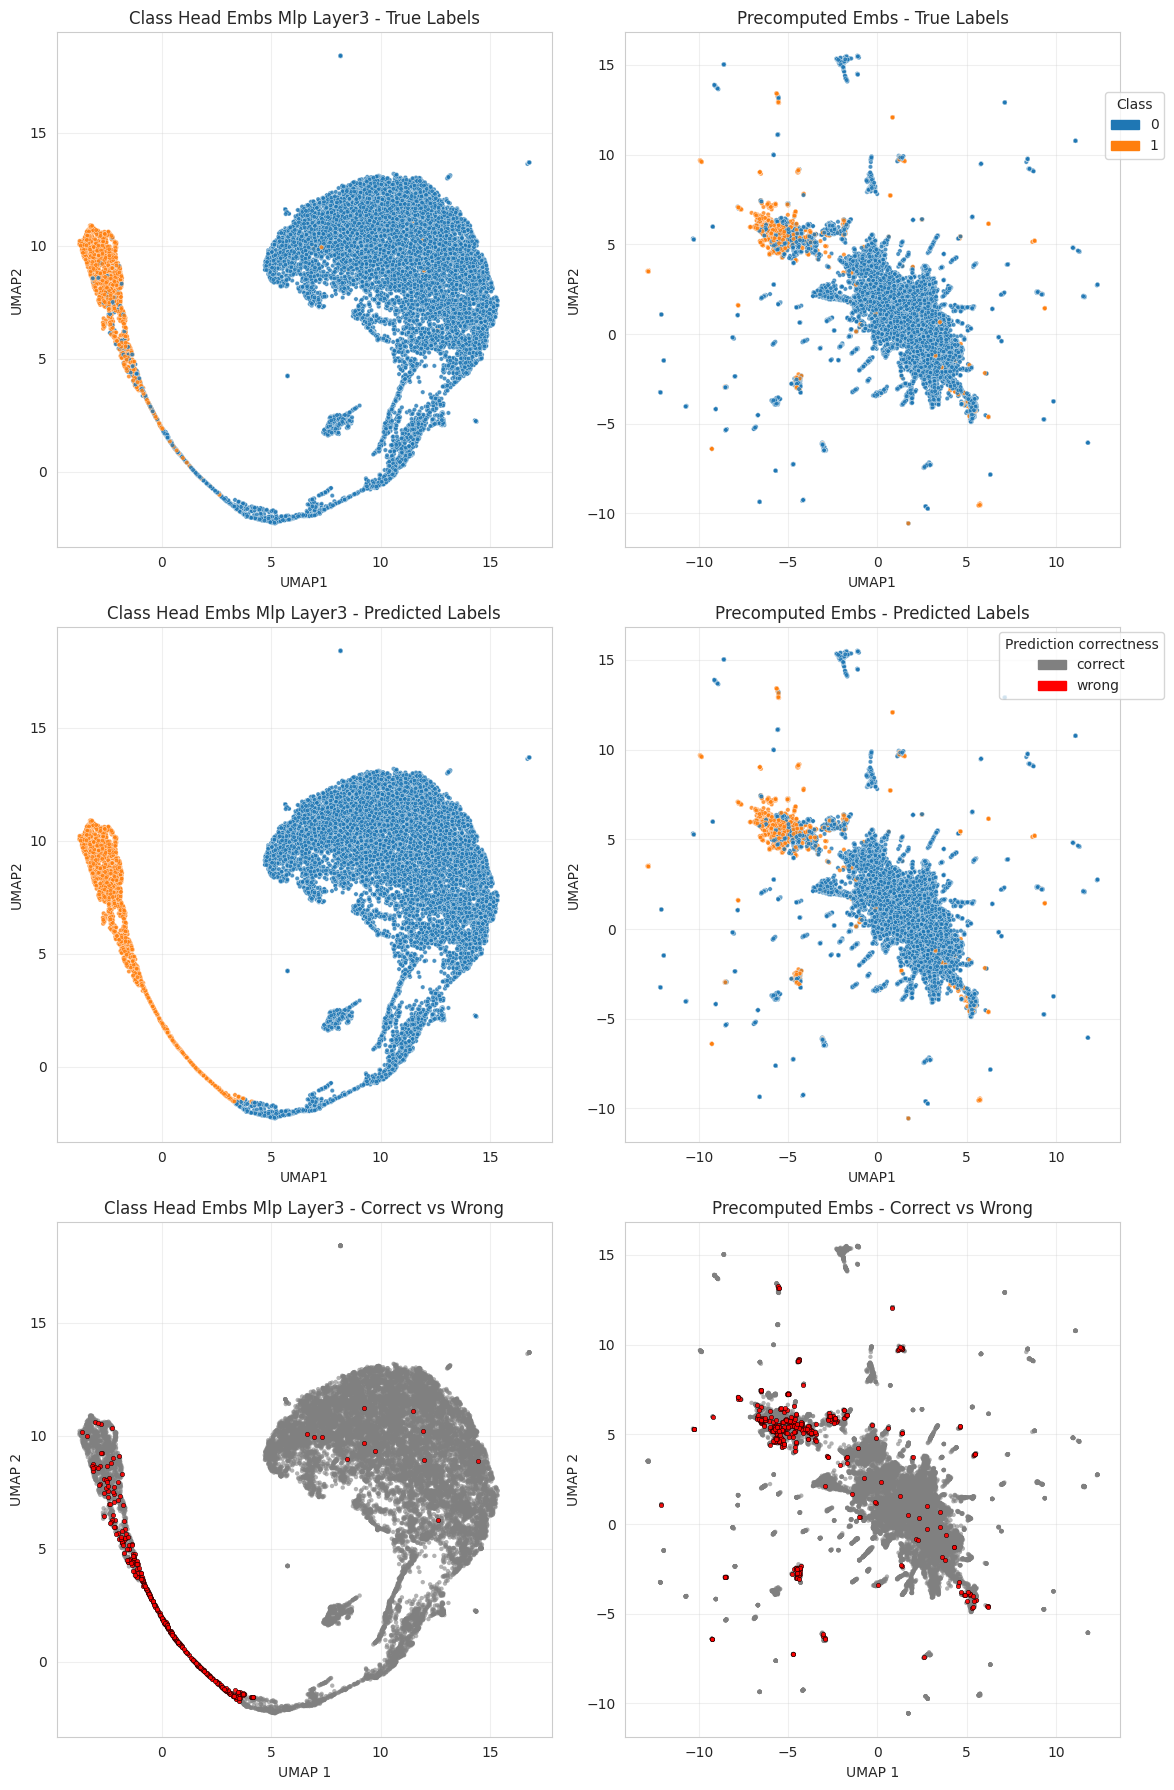

In [16]:
DATALOADER = train_dl

#############################
###### EXTRACT EMBEDDINGS
#############################

print("\nExtracting embeddings from training set...\n")

# Extract embeddings
train_embeddings, names, labels, predictions = my_embs.extract_embeddings(
    net=net,
    dl=DATALOADER,
    device=config["DEVICE"],
    return_numpy=True, # set to False if you want torch tensors instead
    from_precomputed_embs=config["FROM_PRECOMPUTED_EMBS"]
)

print("All possbile embedding given current model architecrure:")
# Example: check shapes
for key, emb in train_embeddings.items():
    if (emb is not None):
        print(f"{key}: {emb.shape}")

# for key, emb in train_embeddings.items():
#     if emb is not None:
#         print(f"\n{key}:")
#         print(f"  Type: {type(emb)}")
#         print(f"  Shape: {emb.shape}")
#         print(f"  Dtype: {emb.dtype}")
#         print(f"  Contains NaN: {np.isnan(emb).any()}")
#         print(f"  Contains Inf: {np.isinf(emb).any()}")
#         print(f"  Min: {np.nanmin(emb) if emb.size > 0 else 'empty'}")
#         print(f"  Max: {np.nanmax(emb) if emb.size > 0 else 'empty'}")
#         print(f"  All NaN: {np.isnan(emb).all()}")
#     else:
#         print(f"\n{key}: None")

#############################
###### CALCULATE UMAP
#############################

print("\nComputing UMAP embeddings...\n")

umap_tensors = my_embs.compute_umap_tensors( #dict of tensors
    embeddings_dict=train_embeddings,
    #n_neighbors=30,
    #min_dist=0.5
)

#############################
###### PLOT
#############################

print("\nPlotting UMAP embeddings...\n")

if len(list(train_embeddings)) != 0:
    df = my_embs.plot_umap_embeddings(
        umap_tensors, 
        names, 
        labels, 
        predictions, 
        class_palette = {str(k): v for k, v in enumerate(sns.color_palette("tab10", num_classes))},
        point_size=10,
        save_path = os.path.join(config["RESULTS_FOLDER_PATH"], "umap_train.pdf")
        )
else:
    print("No embs to plot")

In [17]:
df_precomputed_train = df["precomputed_embs"].copy()
#df_precomputed = df["class_head_embs_mlp_layer3"].copy()

Clustering complete. Added 'Cluster_Label' column to the DataFrame.
     Name     UMAP1     UMAP2 TrueClass PredClass CorrectStr  Cluster_Label
0  Q16829  0.784742 -0.022648         0         0    correct              3
1  A6H8M9 -3.034004 -6.137770         0         0    correct              4
2  P29803 -2.457246  2.333769         0         0    correct              3
3  P06703 -4.703833 -7.251467         0         0    correct              4
4  Q53GL7  1.400659  1.775357         0         0    correct              3


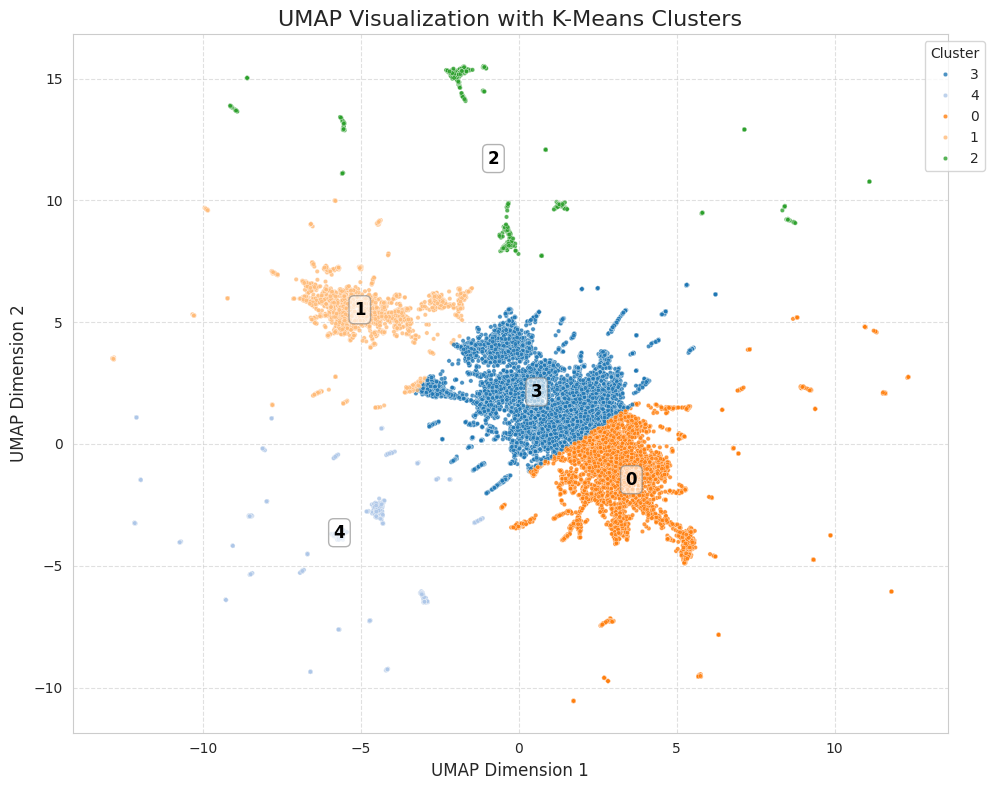

In [18]:
from sklearn.cluster import KMeans

# Define the features for clustering (the UMAP coordinates)
X_for_clustering = df_precomputed_train[['UMAP1', 'UMAP2']]

# Define the number of clusters (you should optimize this, e.g., using the Elbow Method)
K = 5

# Initialize and fit the K-Means model
kmeans = KMeans(n_clusters=K, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(X_for_clustering)

# Save the cluster labels back to the DataFrame
df_precomputed_train['Cluster_Label'] = cluster_labels
print(f"Clustering complete. Added 'Cluster_Label' column to the DataFrame.")
print(df_precomputed_train.head())

my_embs.plot_umap_clusters(df_precomputed_train, point_size=10)

In [19]:
print(df_precomputed_train[df_precomputed_train.Cluster_Label == 2].Name.to_list()) 
print(df_precomputed_train[df_precomputed_train.Cluster_Label == 4].Name.to_list()) 

['P41595', 'Q8TDU5', 'Q8NGT9', 'Q8WZ92', 'P21860', 'P30556', 'Q86WK6', 'P0DN82', 'Q8NGN8', 'P49913', 'Q8NGQ1', 'P35858', 'Q8TDV0', 'A0A075B6H9', 'P68363', 'P59534', 'P21731', 'Q8N6Y2', 'Q8TCC7', 'P62805', 'Q96AM1', 'Q8NGC9', 'Q13639', 'P0DTA3', 'Q9GZK3', 'Q96P65', 'Q14973', 'Q8NG76', 'Q9Y585', 'P25929', 'O43603', 'Q9H228', 'O76001', 'Q8NGH3', 'Q9UJ42', 'Q8NGJ0', 'Q9UBX1', 'Q8NH54', 'Q6IFN5', 'Q8NGQ2', 'Q86VW1', 'Q8NGE2', 'Q8NGT9', 'Q13509', 'Q8N386', 'Q9BRY0', 'A0A1B0GX68', 'O60431', 'P01699', 'P04000', 'Q6UXK5', 'O15455', 'A0A0A0MS01', 'Q8NGS7', 'Q8NGM8', 'Q9P1P5', 'A6NF89', 'Q8NGI7', 'P08571', 'Q8NGE3', 'Q8NGB2', 'Q9GZU5', 'A6NKX4', 'P59540', 'Q5W188', 'P62805', 'A4D2G3', 'Q8NG77', 'P01706', 'O14804', 'Q9BQ66', 'Q8IVM8', 'P25025', 'Q9NYM4', 'Q15619', 'P51686', 'Q86SJ2', 'Q9BYQ4', 'P01704', 'Q9H1C0', 'Q8NGN1', 'Q8NGZ0', 'A0A075B6S9', 'A0A0B4J1U4', 'A0A494C0Z2', 'Q9NYV7', 'A0A075B6I3', 'A0A0J9YX06', 'A6NND4', 'Q8NGS6', 'P11597', 'Q8NGI9', 'P49019', 'P01601', 'P04001', 'Q9UPC5', 'Q9NZP0

In [20]:
# wrong lablled
display(df_precomputed_train[(df_precomputed_train.CorrectStr == "correct") & (df_precomputed_train.TrueClass == "1")].head(5))

print("\nFalse postives")
FP_df = df_precomputed_train[(df_precomputed_train.TrueClass == "0") & (df_precomputed_train.PredClass == "1")]
print(FP_df.Name.to_list())
display(FP_df)

print("\nFalse Negatives")
FN_df = df_precomputed_train[(df_precomputed_train.TrueClass == "1") & (df_precomputed_train.PredClass == "0")]
print(FN_df.Name.to_list())
display(FN_df)

Name     UMAP1     UMAP2 TrueClass PredClass CorrectStr  Cluster_Label
16  A8K7I4 -3.777207  5.489848         1         1    correct              1
19  P0DML3 -7.771066  7.055624         1         1    correct              1
39  P20382 -6.729671  6.542294         1         1    correct              1
41  Q2MKA7 -5.781656  5.614280         1         1    correct              1
50  Q93098 -4.579043  6.827845         1         1    correct              1


False postives
['Q5VXM1', 'Q96DZ1', 'O95274', 'O75063', 'Q6P7N7', 'P34810', 'Q8N423', 'Q14956', 'Q7Z410', 'P06731', 'Q14210', 'Q07075', 'Q6P179', 'Q8N4C9', 'O75324', 'P30533', 'P78552', 'Q8WWQ8', 'Q9UBX1', 'Q6UWN5', 'O60477', 'Q9BZM4', 'P40200', 'P08246', 'Q6UXK5', 'A0A0A0MS01', 'A0A1W2PQU2', 'P20916', 'Q9HB29', 'A2RUT3', 'Q9NS85', 'Q16549', 'Q6BAA4', 'P10586', 'Q9NZ08', 'P54652', 'Q6Q4G3', 'E5RG02', 'O95256', 'P22748', 'E5RIL1', 'P57087', 'P50281', 'P14210', 'O43173', 'Q9Y5H6', 'Q16819', 'B4DH59', 'Q8WZ71', 'Q06481', 'Q6UWS5', 'Q96S16', 'O60494', 'P61647', 'P13686', 'Q15762', 'Q16827', 'A6ND01', 'P09668', 'O75022', 'P49184', 'Q93033', 'P27824', 'P09093', 'P13667', 'P14209', 'Q9HAT2', 'P04844', 'P08236', 'P26992', 'Q9UM44', 'Q6ZMR5', 'Q9BQS7', 'Q96PS6', 'P55899', 'Q09327', 'O14657', 'Q6UVK1', 'Q9Y279', 'Q8IVL8', 'B0FP48', 'P16422', 'Q9BYE4', 'Q16832', 'Q9HBE5', 'O95502', 'A0A1W2PP97', 'Q9UKI3', 'Q9NY15', 'Q6UWR7', 'Q6UW63', 'Q9UQV4', 'Q99895', 'P10323', 'P05164', 'P26951', 'Q6UQ28', '

Name     UMAP1     UMAP2 TrueClass PredClass CorrectStr  \
25     Q5VXM1 -5.291211  5.233782         0         1      wrong   
53     Q96DZ1 -4.786131  5.906529         0         1      wrong   
241    O95274 -6.525485  7.447957         0         1      wrong   
258    O75063 -2.513030  6.027967         0         1      wrong   
325    Q6P7N7 -5.531421  5.137082         0         1      wrong   
...       ...       ...       ...       ...       ...        ...   
16025  P11021 -2.098096  3.276213         0         1      wrong   
16092  Q9NX62 -2.659265  6.048465         0         1      wrong   
16162  Q9UMF0 -4.510898 -2.532588         0         1      wrong   
16200  Q92914  4.657475  5.440334         0         1      wrong   
16212  P15289 -3.734144  5.101050         0         1      wrong   

       Cluster_Label  
25                 1  
53                 1  
241                1  
258                1  
325                1  
...              ...  
16025              3  
16092              1  
16162              4  
16200              3  
16212              1  

[409 rows x 7 columns]


False Negatives
['P18827', 'Q96QU1', 'Q9UBR5', 'Q14114', 'P49662', 'Q9BRJ6', 'Q96IU2', 'Q9NP58', 'Q8TC92', 'Q08J23', 'Q9NNX1', 'Q16206', 'Q16623', 'Q8N300', 'Q8N302']


Name     UMAP1     UMAP2 TrueClass PredClass CorrectStr  \
1045   P18827 -6.362807  5.809034         1         0      wrong   
1214   Q96QU1 -3.048064 -6.213999         1         0      wrong   
3158   Q9UBR5 -0.096464  4.788853         1         0      wrong   
3350   Q14114 -5.716186  5.110117         1         0      wrong   
3774   P49662  5.438544  3.848749         1         0      wrong   
4271   Q9BRJ6  1.748863  0.524421         1         0      wrong   
6630   Q96IU2  2.320292  0.361582         1         0      wrong   
8154   Q9NP58 -1.051340  4.236189         1         0      wrong   
8471   Q8TC92  2.167545 -0.807656         1         0      wrong   
11079  Q08J23  0.202232  2.329730         1         0      wrong   
11181  Q9NNX1  4.304731 -1.255563         1         0      wrong   
11375  Q16206  2.259816 -0.885647         1         0      wrong   
13194  Q16623  1.992729  3.751937         1         0      wrong   
13764  Q8N300  3.516350 -0.154963         1         0      wrong   
15586  Q8N302  3.510021  0.663475         1         0      wrong   

       Cluster_Label  
1045               1  
1214               4  
3158               3  
3350               1  
3774               3  
4271               3  
6630               0  
8154               3  
8471               0  
11079              3  
11181              0  
11375              0  
13194              3  
13764              0  
15586              0


Extracting embeddings from training set...



All possbile embedding given current model architecrure:
class_head_embs_mlp_layer3: (4064, 32)
precomputed_embs: (4064, 2560)

Computing UMAP embeddings...

Computing UMAP for class_head_embs_mlp_layer3 with shape (4064, 32)...
Computing UMAP for precomputed_embs with shape (4064, 2560)...

Plotting UMAP embeddings...


✅ Embedding plot saved to: /home/gdallagl/myworkdir/ESMSec/data/model_results/secreted_Uniprot-locations_03_dataset_final_sample-neg=False/umap_test.pdf


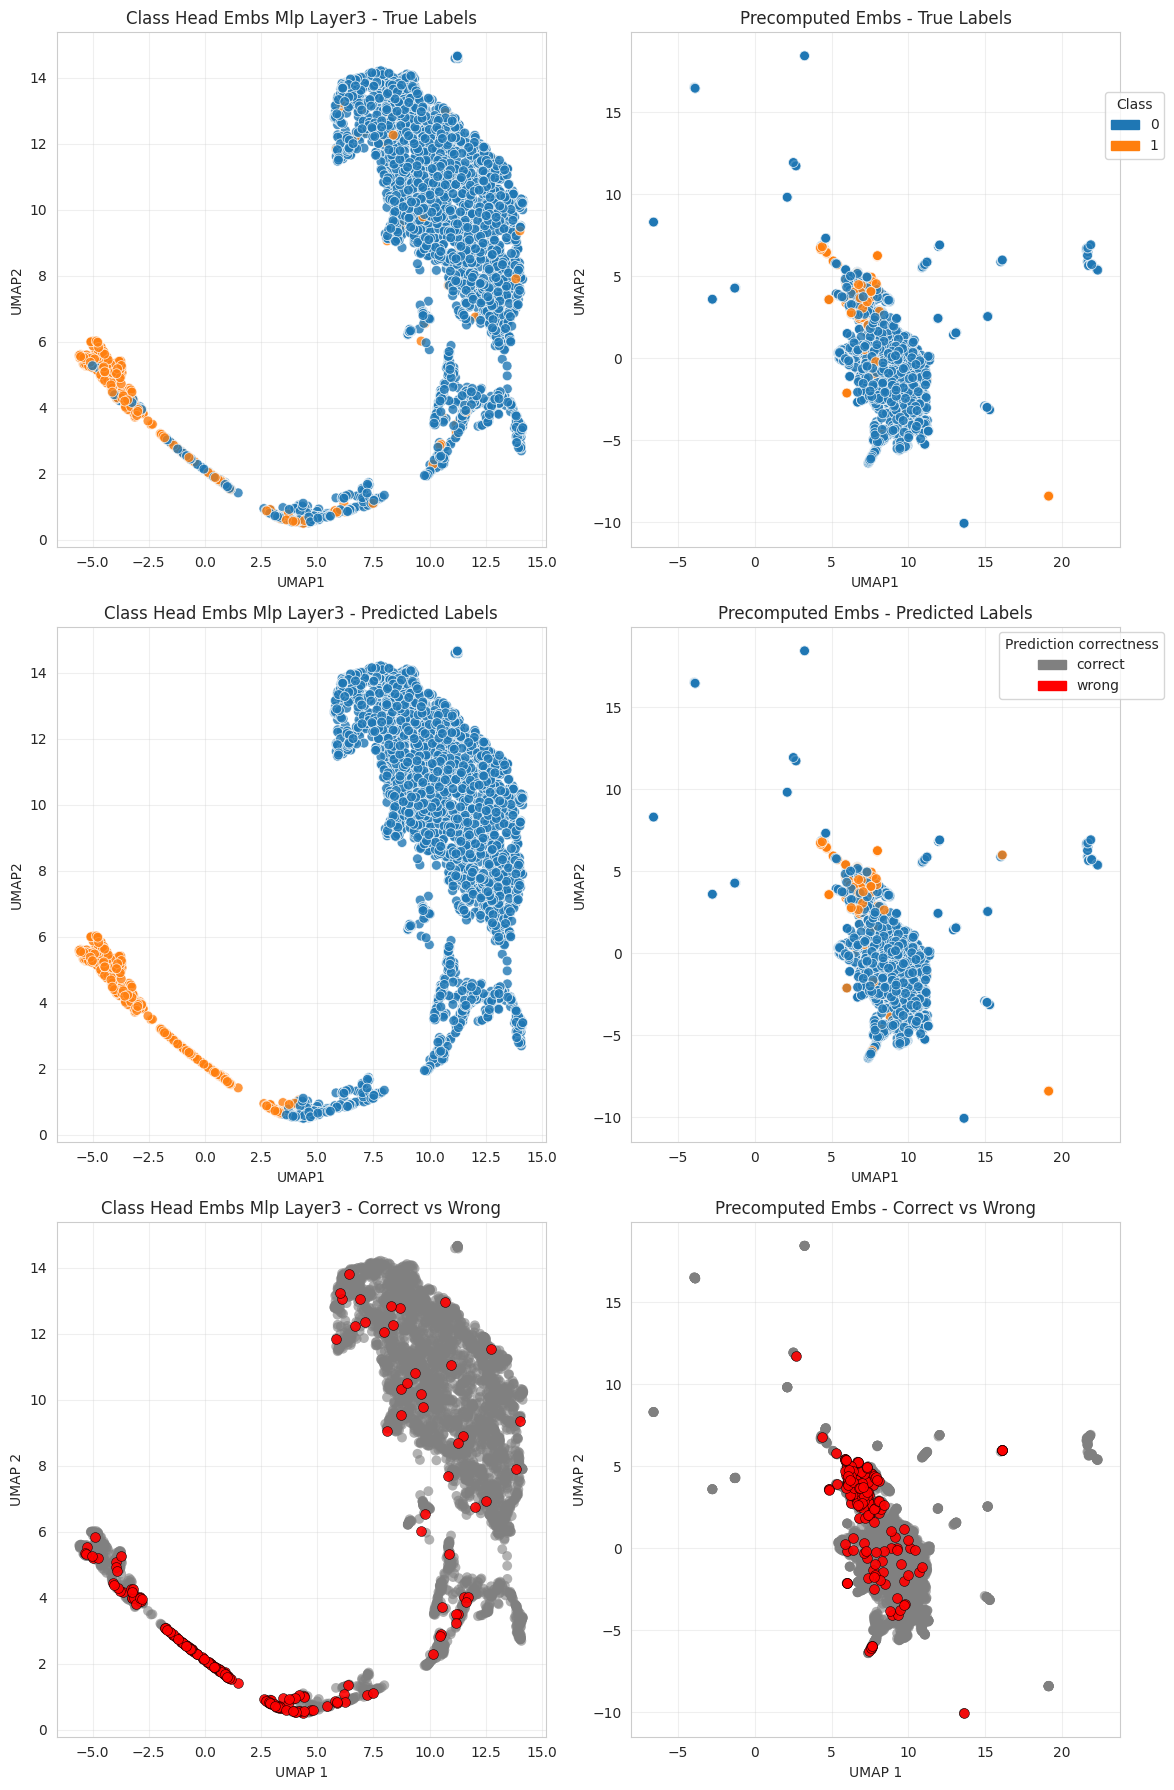

In [21]:
DATALOADER = test_dl

#############################
###### EXTRACT EMBEDDINGS
#############################

print("\nExtracting embeddings from training set...\n")

# Extract embeddings
train_embeddings, names, labels, predictions = my_embs.extract_embeddings(
    net=net,
    dl=DATALOADER,
    device=config["DEVICE"],
    return_numpy=True, # set to False if you want torch tensors instead
    from_precomputed_embs=config["FROM_PRECOMPUTED_EMBS"]
)

print("All possbile embedding given current model architecrure:")
# Example: check shapes
for key, emb in train_embeddings.items():
    if (emb is not None):
        print(f"{key}: {emb.shape}")

#############################
###### CALCULATE UMAP
#############################

print("\nComputing UMAP embeddings...\n")

umap_tensors = my_embs.compute_umap_tensors( #dict of tensors
    embeddings_dict=train_embeddings,
)

#############################
###### PLOT
#############################

print("\nPlotting UMAP embeddings...\n")

if len(list(train_embeddings)) != 0:
    df = my_embs.plot_umap_embeddings(
        umap_tensors,
        names, 
        labels, 
        predictions, 
        class_palette = {str(k): v for k, v in enumerate(sns.color_palette("tab10", num_classes))},
        point_size=50,
        save_path = os.path.join(config["RESULTS_FOLDER_PATH"], "umap_test.pdf")
        )
else:
    print("No embs to plot")

In [22]:
train_embeddings["class_head_embs_mlp_layer3"]

array([[0.        , 0.        , 1.6640028 , ..., 0.20237967, 1.9339381 ,
        0.        ],
       [0.        , 0.        , 1.8421031 , ..., 0.        , 1.7751116 ,
        0.        ],
       [0.        , 0.        , 1.8428445 , ..., 0.03422014, 1.7651162 ,
        0.        ],
       ...,
       [0.        , 0.        , 1.578623  , ..., 0.        , 0.46735612,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 1.7900944 , ..., 0.08476242, 1.7845083 ,
        0.        ]], dtype=float32)

In [23]:
df_precomputed = df["precomputed_embs"].copy()
#df_precomputed = df["class_head_embs_mlp_layer3"].copy()

# PCA on embs
from sklearn.decomposition import PCA
pca = PCA()
pca.fit(train_embeddings["class_head_embs_mlp_layer3"])
print(pca.explained_variance_ratio_)


# wrong lablled
TP_df = df_precomputed[(df_precomputed.CorrectStr == "correct") & (df_precomputed.TrueClass == "1")]
print(TP_df.Name.to_list())
display(TP_df)

FP_df = df_precomputed[(df_precomputed.TrueClass == "0") & (df_precomputed.PredClass == "1")]
print(FP_df.Name.to_list())
display(FP_df)

print("\nFalse Negatives")
FN_df = df_precomputed[(df_precomputed.TrueClass == "1") & (df_precomputed.PredClass == "0")]
print(FN_df.Name.to_list())
display(FN_df)

[9.4912887e-01 3.4346070e-02 4.1897194e-03 2.9960100e-03 1.9974411e-03
 1.8408531e-03 9.8091597e-04 8.2741719e-04 7.3132326e-04 6.3410943e-04
 5.2103569e-04 4.4632322e-04 3.8524217e-04 2.9776347e-04 2.4138788e-04
 2.2074768e-04 1.9703513e-04 1.0845078e-05 2.6271207e-06 2.0161685e-06
 1.5633982e-06 3.0692823e-07 2.0677028e-07 1.3336135e-07 1.6444300e-08
 7.7898783e-18 1.7748243e-19 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00]
['Q9BZM2', 'Q96A83', 'P07358', 'P00736', 'P59510', 'Q9NQ38', 'P28799', 'P80188', 'Q9NRI6', 'Q86Y38', 'P02458', 'A8MZH6', 'E2RYF7', 'Q8WX77', 'Q96DR5', 'Q16787', 'A0A0C4DH34', 'O00602', 'Q9BWP8', 'O94813', 'P04114', 'Q14118', 'P0CF74', 'Q9UHA7', 'A0A0C4DH72', 'Q9NRC9', 'P39059', 'Q95460', 'O00585', 'P01303', 'P22301', 'P81534', 'Q9NZK7', 'P15515', 'P54317', 'Q15828', 'Q7RTW8', 'Q9UHG2', 'P0DJD8', 'Q9UM22', 'Q6X784', 'A0A087WSY6', 'Q7L8A9', 'Q7Z7B8', 'A0A0A0MRZ9', 'P12109', 'Q6UXI7', 'P83859', 'P48551', 'P01615', 'Q86YQ2', 'P0DJD7', 'O75830

Name     UMAP1     UMAP2 TrueClass PredClass CorrectStr
3     Q9BZM2  6.885091  3.550438         1         1    correct
6     Q96A83  7.224669  4.142698         1         1    correct
13    P07358  6.613307  3.822769         1         1    correct
29    P00736  6.221117  3.972319         1         1    correct
57    P59510  6.328786  3.579104         1         1    correct
...      ...       ...       ...       ...       ...        ...
3985  O43240  4.833565  3.570092         1         1    correct
4021  O95841  7.564352  4.073205         1         1    correct
4057  P01011  6.286721  2.776119         1         1    correct
4060  Q7RTY5  4.829247  3.572740         1         1    correct
4062  Q6JVE5  6.759682  4.490276         1         1    correct

[359 rows x 6 columns]

['Q8N441', 'Q8NI22', 'Q9Y2Y8', 'P16234', 'A0A0B4J2A2', 'P15088', 'Q9P232', 'P04156', 'Q9Y6X5', 'Q05BU3', 'O95944', 'P11717', 'Q6ZPB5', 'P56159', 'Q9Y215', 'P09758', 'Q7Z4H8', 'P08842', 'O00451', 'Q8WWV6', 'P50454', 'A0A075B759', 'Q4G0T1', 'Q14392', 'P01589', 'P15529', 'P52803', 'P06729', 'H3BQJ8', 'Q8IVL5', 'P20930', 'O00526', 'Q9Y624', 'Q6ISU1', 'Q96L12', 'P59901', 'A0A075B6L2', 'P54289', 'P08195', 'O43612', 'F5H284', 'Q96KR4', 'Q9NRR2', 'P22735', 'Q7Z4F1', 'P59025', 'Q7L0X0', 'Q86YC3', 'Q9H3S1', 'P0DN37', 'P28827', 'O00478', 'P51690', 'Q3B8N2', 'P17900', 'P13598', 'P51511', 'Q6UXH1', 'Q9Y219', 'Q9H1U4', 'Q6NUS6', 'Q9UMR5', 'P55786', 'Q9C0C4', 'Q15165', 'Q8N8Z6', 'Q8N9C0', 'Q7RTU9', 'Q92542', 'P20160', 'Q9UBM8', 'Q86UQ8', 'O75023', 'Q9Y536', 'Q8NBJ4', 'A6NHM9', 'Q96NR8', 'Q6UWV6', 'Q14554', 'O76036', 'P56202', 'P43489', 'O75900', 'Q9H1A3', 'P42785', 'Q8WY21', 'O15031', 'Q9UKU6', 'A0A494C103', 'Q15154', 'O00548', 'P54826', 'P26436', 'Q99795', 'Q496F6', 'Q5ZPR3', 'P0CH98', 'O43396', 'Q1

Name      UMAP1     UMAP2 TrueClass PredClass CorrectStr
39        Q8N441   6.051312  4.432587         0         1      wrong
80        Q8NI22   7.413140  3.238103         0         1      wrong
110       Q9Y2Y8   7.572530  4.568674         0         1      wrong
160       P16234   6.006969  3.982874         0         1      wrong
218   A0A0B4J2A2  16.116558  5.986579         0         1      wrong
...          ...        ...       ...       ...       ...        ...
3905      Q5VV43   6.201738  4.152331         0         1      wrong
3924      P0C7M8   8.427309  2.636064         0         1      wrong
3987      O43280   6.739150  2.649932         0         1      wrong
3997      Q92791   6.788231  3.692369         0         1      wrong
4040      Q9Y2B0   7.063793  3.750237         0         1      wrong

[156 rows x 6 columns]


False Negatives
['Q99584', 'Q8TCW7', 'P24001', 'P67809', 'P41250', 'Q9UFP1', 'A0A0A0MT89', 'Q8WXW3', 'P31947', 'Q13443', 'Q9Y2Y6', 'P05161', 'Q9Y653', 'P16471', 'Q8WUM4', 'Q9BUR5', 'O14498', 'Q6IE37', 'P07306', 'P0C854', 'O95833', 'P04271', 'P22626', 'O76038', 'P31151', 'Q0P651', 'O75077', 'Q9NR71', 'Q93063', 'Q8TD46', 'O60568', 'Q96F46', 'Q6UX34', 'P55210', 'Q96MS3', 'P51858', 'Q08380', 'Q6P1S2', 'Q9NPG4', 'P14174', 'Q8WUJ3', 'A6NCI4', 'P32455', 'Q9Y287', 'Q9BXJ7', 'Q5EBL8', 'Q8NDZ4', 'Q10471', 'P43251', 'Q14005', 'Q16619', 'O60513', 'A6NE02', 'Q12904', 'P16442', 'Q9BT67', 'Q96HE7', 'P06734', 'Q9BZ76', 'Q13510', 'Q9H3N1', 'Q92982', 'Q969H8', 'O14514']


Name     UMAP1     UMAP2 TrueClass PredClass CorrectStr
103   Q99584  6.013597 -2.110633         1         0      wrong
241   Q8TCW7  6.851247  3.948364         1         0      wrong
560   P24001  8.909813 -4.063732         1         0      wrong
620   P67809  8.508124 -2.153228         1         0      wrong
746   P41250  5.987690 -0.142572         1         0      wrong
...      ...       ...       ...       ...       ...        ...
3846  Q13510  6.871196  2.649910         1         0      wrong
3870  Q9H3N1  7.142605  3.192122         1         0      wrong
3972  Q92982  7.880923 -0.210545         1         0      wrong
3981  Q969H8  7.325542  3.436649         1         0      wrong
3999  O14514  6.868883  3.666842         1         0      wrong

[64 rows x 6 columns]

# A-scanning

In [ ]:
# df_precomputed = df["precomputed_embs"].copy()
# train_correct = df_precomputed[(df_precomputed.CorrectStr == "correct") & (df_precomputed.TrueClass == "1")]
# train_correct

# print(data[data.protein.isin(train_correct.Name)].sequence.apply(len).sort_values().head(10))

# data[data.label==1].iloc[284, :]

In [ ]:
SUBSTITUTE_AA = ["A", "R", "E", "F"] #["inverse"]#["A", "R", "E", "F"]#["<mask>"] ["<pad>", "<unk>", "-", ".", "X"]
WINDOW_SIZE_SUBSTITUION = 5 #int(single_protein_info.trunc_sequence_length * WINDOW_SIZE_FRACTION // 2 * 2 + 1) # make it odd

# Make folder to save
aa_scanning_folder_saving = os.path.join(
    os.path.dirname(config["PRECOMPUTED_EMBS_PATH"]),
    f"aa_scannining_mutations_ebs-aa_sub_[{'_'.join(SUBSTITUTE_AA)}]-window_{WINDOW_SIZE_SUBSTITUION}-model_{config['PRETRAIN_ESM_CHECKPOINT_NAME'].replace('/', '_')}-emb_{config['TYPE_EMB_FOR_CLASSIFICATION']}")
if not os.path.exists(aa_scanning_folder_saving):
    os.makedirs(aa_scanning_folder_saving)
print(aa_scanning_folder_saving)

PROTEINS = df_precomputed_train[(df_precomputed_train.CorrectStr == "correct") & (df_precomputed_train.TrueClass == "1")][:9].Name.to_list()
PROTEINS = ['Q6XE38']#, 'O60575'] # for secreted
# PROTEINS = [ 
#             "P98179", #RMB
#             "P31483", #TIA1
#             "Q5JQF8", #common motif later
#             "P52298",
#             "P51991",
#             "Q9BQ04",
#             ]# for RNA binding
# PROTEINS = ["P17900"] # for lyso
# PROTEINS = ["P63167"
#             ] # for cc
# PROTEINS = [
#  'P06748', # has Nuclear localization signal
#  'O76021',
#  'P62244',
#  'Q8NG66',
#  'Q8WTT2',
#  'Q96HI0',
#  'Q9BQ04',
#  'Q9H7Z3',
#  'Q9NW13'] # for nucleolus

print(PROTEINS)

/home/gdallagl/myworkdir/ESMSec/data/UniProt/precomputed_embs/aa_scannining_mutations_ebs-aa_sub_[A_R_E_F]-window_5-model_facebook_esm2_t36_3B_UR50D-emb_cls
['Q6XE38']


In [26]:
scan_result = {}

for i, P in enumerate(PROTEINS):

    print(i, "-->", P)

    ####################
    # Select single prot info

    idx = [cache_data["protein"].index(P)] # encapslu in a lsit
    selected_protein_data = my_dataset.subset_data_dict(cache_data, idx) #dict
    selected_prot_emb=selected_protein_data["embedding"]
    #print(selected_protein_data)

    ####################
    # create all mutatios

    all_mutated_seqs, mutation_names = my_scanning.create_all_mutations(selected_protein_data["truncated_sequence"][0], WINDOW_SIZE_SUBSTITUION, SUBSTITUTE_AA)
    tot_mutations = len(all_mutated_seqs)
    print("Total mutations:", tot_mutations,  len(list(selected_protein_data["truncated_sequence"][0])) * len(SUBSTITUTE_AA))

    ####################
    # tokenize allmtuations

    # ATTNETION: alredy truncated
    print("Tokenizing...")
    encoded = tokenizer(
        all_mutated_seqs,
        padding='max_length',
        max_length=config["PROTEIN_MAX_LENGTH"],
        truncation=True,
        return_tensors="pt"
    )

    ####################
    # make cache data

    cache_mutations = {
        'protein': mutation_names,
        'sequence': all_mutated_seqs,
        'truncated_sequence': all_mutated_seqs, # alredy trucnated
        'input_ids': encoded["input_ids"],
        'attention_mask': encoded["attention_mask"],

        'embedding': torch.zeros((tot_mutations, 1), dtype=torch.float32), # FAKE
        'label': torch.zeros(tot_mutations, dtype=torch.long), # FAKE
        'set': torch.zeros((tot_mutations, 1), dtype=torch.float32), # FAKE
    }
    # display(cache_mutations["truncated_sequence"][:10])
    # print(np.asarray(cache_mutations["input_ids"][:10, :10]))

    ####################
    # Save mutations embs

    mutations_embs_path = os.path.join(
        aa_scanning_folder_saving,
        f"{P}.safetensors")
    mutations_names_path=mutations_embs_path.replace('.safetensors', '_names.json')

    if not os.path.exists(mutations_embs_path):
        my_dataset.create_uniprot_embs(
            esm_model=esm_model,
            config=config, 
            cache_data=cache_mutations, 
            num_samples=tot_mutations, 
            save_embs_path=mutations_embs_path,
            save_names_path=mutations_names_path,
            emb_dim=config["PRECOMPUTED_EMBS_DIM"]
        )

    embs_mutations, protein_names_selected = my_dataset.load_embs_safetensor(
        precomputed_embs_path=mutations_embs_path, # path with tensors
        protein_names_path=mutations_names_path, # path with the prtein names of the tenoser
        protein_to_select=None # take all
    )

    cache_mutations["embedding"] = embs_mutations

    #check
    print(protein_names_selected == cache_mutations["protein"])

    ####################
    # Make dataloder
    mutations_dl = my_dataset.create_dataloader(cache_mutations, config["BATCH_SIZE"], shuffle=False) 
    names_mutations = cache_mutations["protein"]


    ##############################
    # calcualte baseline prob

    wt_dl = my_dataset.create_dataloader(selected_protein_data, batch_size=1, shuffle=False) 
    wt_dict = mf.evaluate_model(
                net=net, 
                dl=wt_dl,
                device=config["DEVICE"], 
                loss_fn=net.loss_fn,
                split_name="WT prot", 
                verbose=False,
                from_precomputed_embs=True
            )
    baseline_prob = float(wt_dict["probs_class1"][0])
    print(baseline_prob)

    ##############################
    # calculate prob for each utation

    scan_results_tmp = my_scanning.multi_aa_scanning_tmp(
        model=net,
        baseline_prob=baseline_prob,
        mutations_dl=mutations_dl,
        names_mutations=names_mutations,
        substitute_aas=SUBSTITUTE_AA,
        wt_seq=selected_protein_data["truncated_sequence"][0],
        prot_name=P, 
        device=config["DEVICE"], 
    )

    scan_result[P] = scan_results_tmp

# Save results
aa_scanning_scan_result_path = os.path.join(
        aa_scanning_folder_saving,
        f"scan_results.json")
with open(aa_scanning_scan_result_path, 'w') as f:
    json.dump(scan_result, f, indent=4)

# Load data
with open(aa_scanning_scan_result_path, 'r') as f:
    # Use json.load() to deserialize the data from the file object 'f'
    scan_result = json.load(f)

clear_output(wait=True)

0 --> Q6XE38


Generating mutations:   0%|          | 0/83 [00:00<?, ?it/s]

Generating mutations: 100%|██████████| 83/83 [00:00<00:00, 36796.03it/s]

Total mutations: 332 332
Tokenizing...


Loading embeddings from: /home/gdallagl/myworkdir/ESMSec/data/UniProt/precomputed_embs/aa_scannining_mutations_ebs-aa_sub_[A_R_E_F]-window_5-model_facebook_esm2_t36_3B_UR50D-emb_cls/Q6XE38.safetensors
✓ Mapped 332 embeddings (shape: torch.Size([332, 2560]))
✓ Loaded 332 / 332 embeddings
  Shape: torch.Size([332, 2560])
  Memory: 3.2 MB
True


Evaluation:   0%|          | 0/1 [00:00<?, ? WT prot batch/s]

0.9932877421379089


/home/gdallagl/.pyenv/versions/esm2_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:534: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/home/gdallagl/.pyenv/versions/esm2_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:534: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/home/gdallagl/.pyenv/versions/esm2_env/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


Evaluation:   0%|          | 0/3 [00:00<?, ? mutations batch/s]

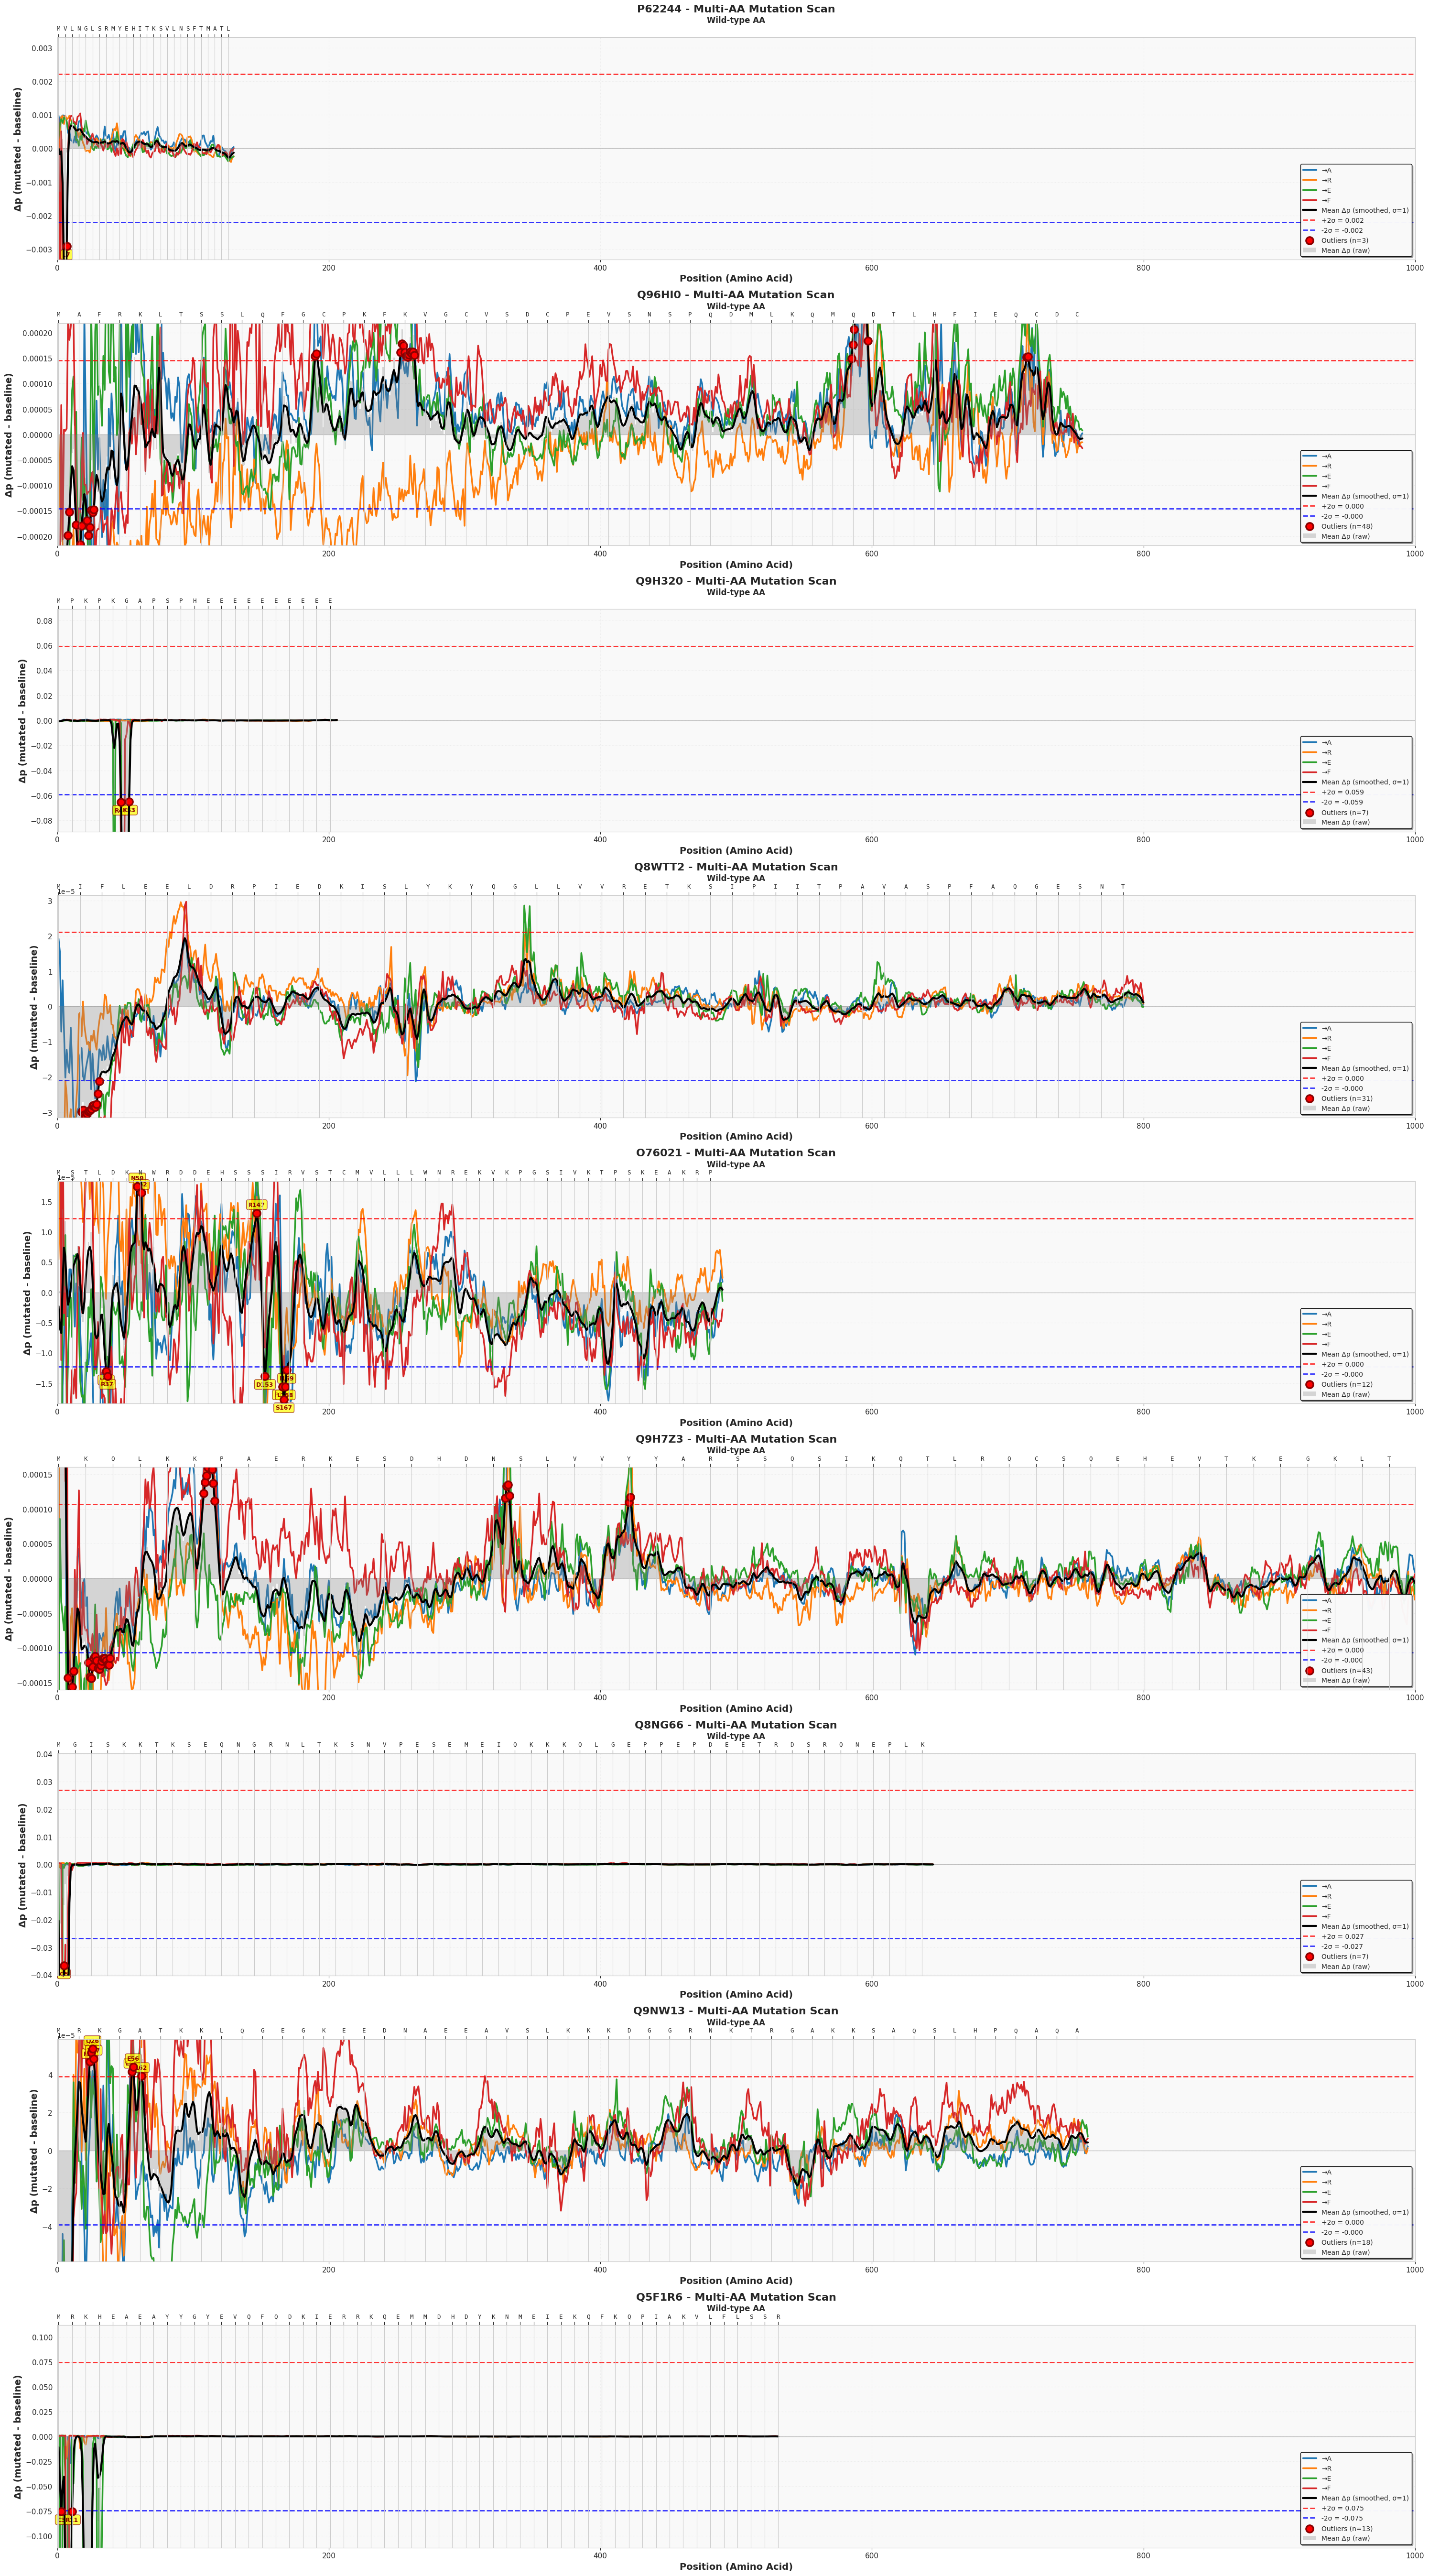

✅ Saved combined figure as all_proteins_scans.png


In [ ]:
n = len(PROTEINS)
fig, axes = plt.subplots(n, 1, figsize=(30, 6 * n), sharex=False)

if n == 1:
    axes = [axes]  # make iterable

for ax, P in zip(axes, PROTEINS):
    my_scanning.plot_multi_aa_scan(
        scan_result[P],
        sigma=1,
        palette='RdBu_r',
        show_per_aa=True,
        xlim=[0, 1000], # common for all (even if a protein is shorter)
        ax=ax,  #  draw directly into subplot
        sub_aa_for_mean=None
    )
    ax.set_title(f"{P} - Multi-AA Mutation Scan", fontsize=16, fontweight="bold")

plt.tight_layout()
plt.savefig(os.path.join(config["RESULTS_FOLDER_PATH"], "scanning.png"), dpi=300)
plt.show(fig)
print("✅ Saved combined figure as all_proteins_scans.png")

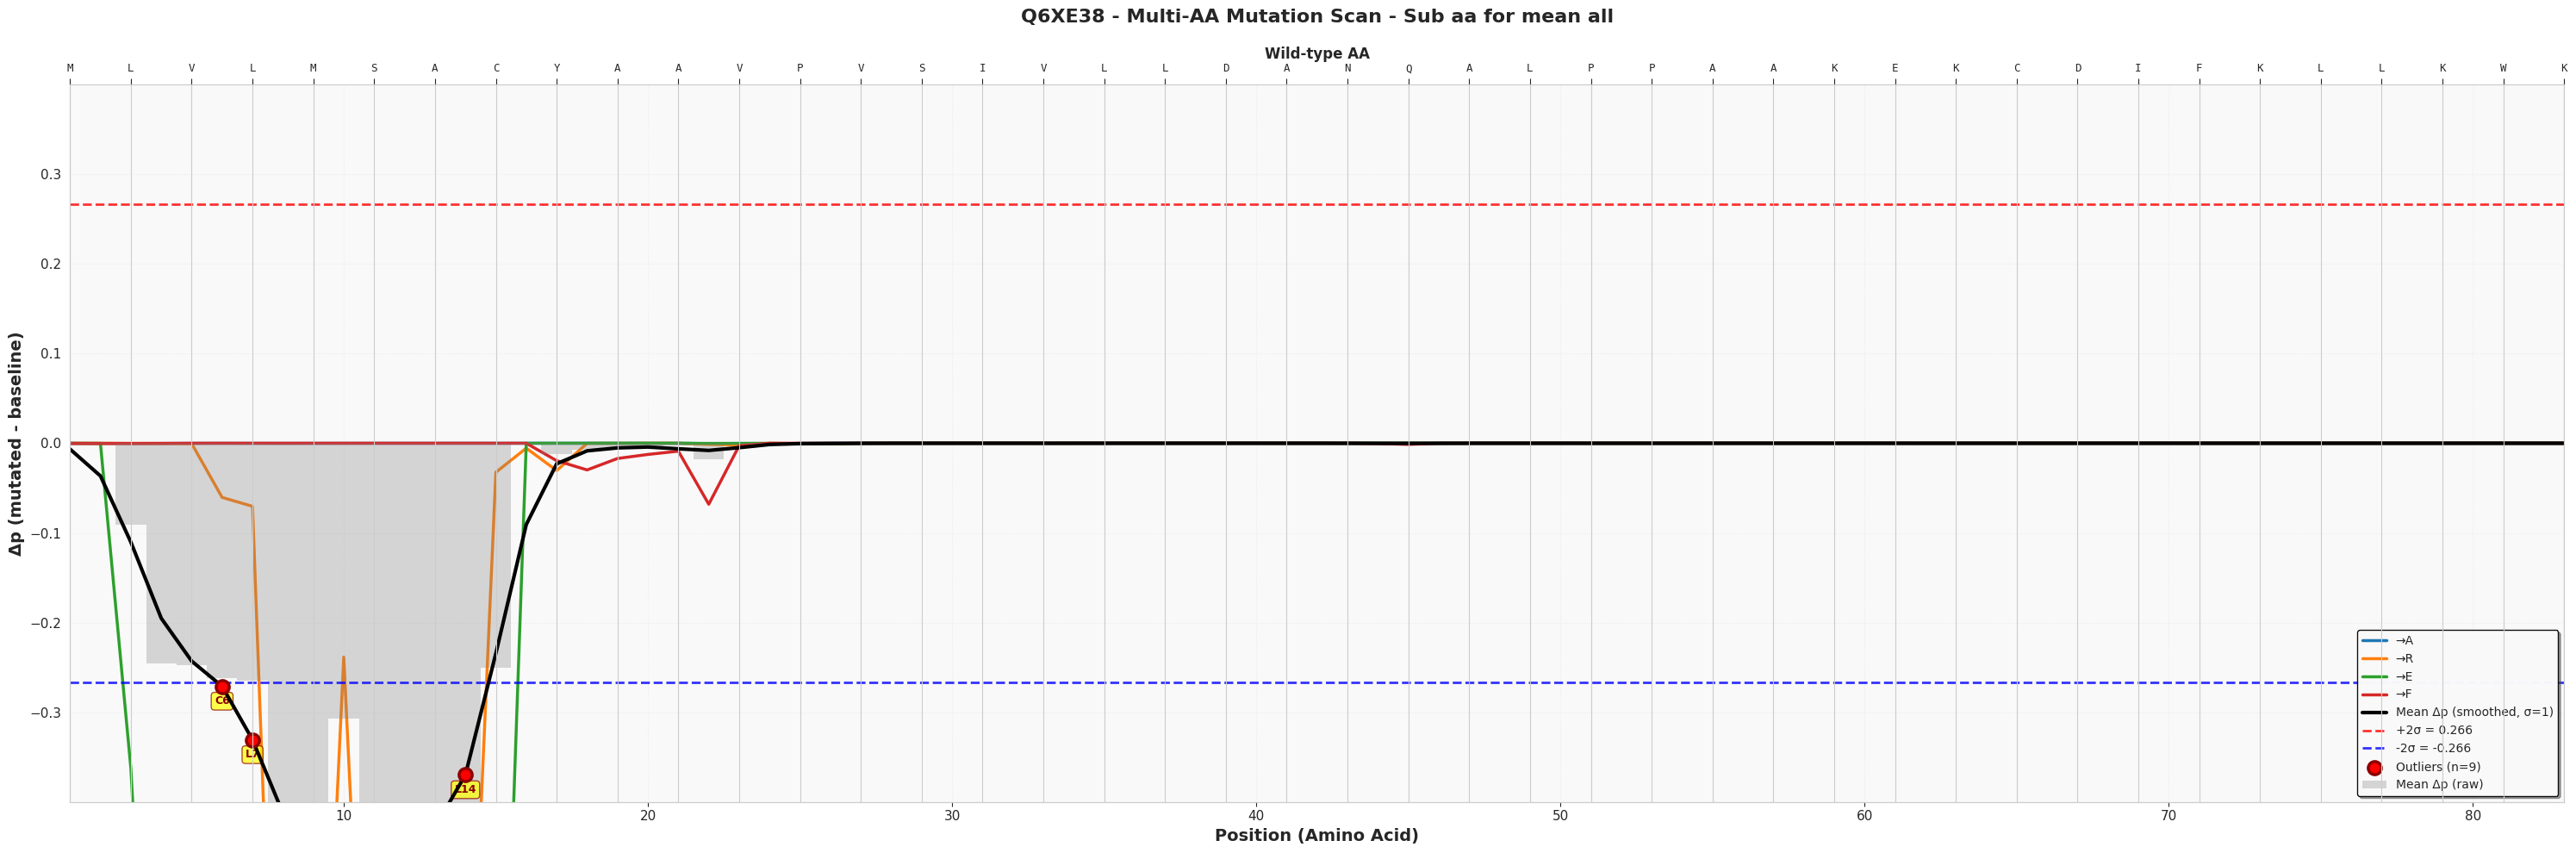

In [27]:
for P in PROTEINS:
    my_scanning.plot_multi_aa_scan(
                            scan_result[P], sigma=1,figsize=(30, 10), show_per_aa=True, ax=None,
                            #sub_aa_for_mean=["A", "R", "E", "F"]#,, "<unk>", "-", ".", "X"],#"A", "R", "E"], ["<pad>", "<unk>", "-", ".", "X"]
                            #, xlim=[0,1000]
                            )


# Plot mutations embs

In [ ]:
PROTEIN = PROTEINS[0]

import numpy as np
import pandas as pd
import umap

# ============================================================
# 1️⃣ UMAP fitted only on dataset
# ============================================================
umap_model_dataset = umap.UMAP(
    n_neighbors=15,
    min_dist=0.1,
    random_state=42,
    n_jobs=1
)

umap_model_dataset.fit(all_dataset_embs)

umap_dataset_all_dataset = umap_model_dataset.transform(all_dataset_embs)
umap_dataset_mutations = umap_model_dataset.transform(embs_mutations)
umap_dataset_selected = umap_model_dataset.transform(selected_prot_emb)

# ============================================================
# 2️⃣ UMAP fitted on all embeddings
# ============================================================
combined_embs = np.concatenate([all_dataset_embs, embs_mutations, selected_prot_emb], axis=0)

umap_model_all = umap.UMAP(
    n_neighbors=15,
    min_dist=0.1,
    random_state=42,
    n_jobs=1
)

umap_model_all.fit(combined_embs)

umap_all_dataset = umap_model_all.transform(all_dataset_embs)
umap_all_mutations = umap_model_all.transform(embs_mutations)
umap_all_selected = umap_model_all.transform(selected_prot_emb)

# ============================================================
# 3️⃣ Combine into one DataFrame
# ============================================================
df_dataset = pd.DataFrame({
    'Name': protein_names_selected_all_dataset,
    'Source': ['Dataset'] * len(protein_names_selected_all_dataset),
    'Position': [None] * len(protein_names_selected_all_dataset),
    'Sub_aa': [None] * len(protein_names_selected_all_dataset),
    'UMAP1_datasetOnly': umap_dataset_all_dataset[:, 0],
    'UMAP2_datasetOnly': umap_dataset_all_dataset[:, 1],
    'UMAP1_allData': umap_all_dataset[:, 0],
    'UMAP2_allData': umap_all_dataset[:, 1],
})

df_mutations = pd.DataFrame({
    'Name': protein_names_selected,
    'Source': ['Mutations'] * len(protein_names_selected),
    'Position': [int(n.split('_')[0]) for n in protein_names_selected],
    'Sub_aa': [n.split('_')[1] for n in protein_names_selected],
    'UMAP1_datasetOnly': umap_dataset_mutations[:, 0],
    'UMAP2_datasetOnly': umap_dataset_mutations[:, 1],
    'UMAP1_allData': umap_all_mutations[:, 0],
    'UMAP2_allData': umap_all_mutations[:, 1],
})

df_selected = pd.DataFrame({
    'Name': [PROTEIN],
    'Source': ['Selected'],
    'Position': [None],
    'Sub_aa': [None],
    'UMAP1_datasetOnly': umap_dataset_selected[:, 0],
    'UMAP2_datasetOnly': umap_dataset_selected[:, 1],
    'UMAP1_allData': umap_all_selected[:, 0],
    'UMAP2_allData': umap_all_selected[:, 1],
})

# Combine all
df_umap_combined = pd.concat([df_dataset, df_mutations, df_selected], ignore_index=True)

df_umap_combined.head()


Name   Source Position Sub_aa  UMAP1_datasetOnly  UMAP2_datasetOnly  \
0  A6NDE4  Dataset     None   None          -0.291406           1.133000   
1  O00425  Dataset     None   None           0.027966           1.181752   
2  O75494  Dataset     None   None          -0.094031           1.158006   
3  P09651  Dataset     None   None          -0.078386           1.160635   
4  P0DJD3  Dataset     None   None          -0.293390           1.126842   

   UMAP1_allData  UMAP2_allData  
0       8.576315      -0.831192  
1       8.011336      -0.563299  
2       8.399386      -0.748201  
3       8.069930      -0.591139  
4       8.589099      -0.822520

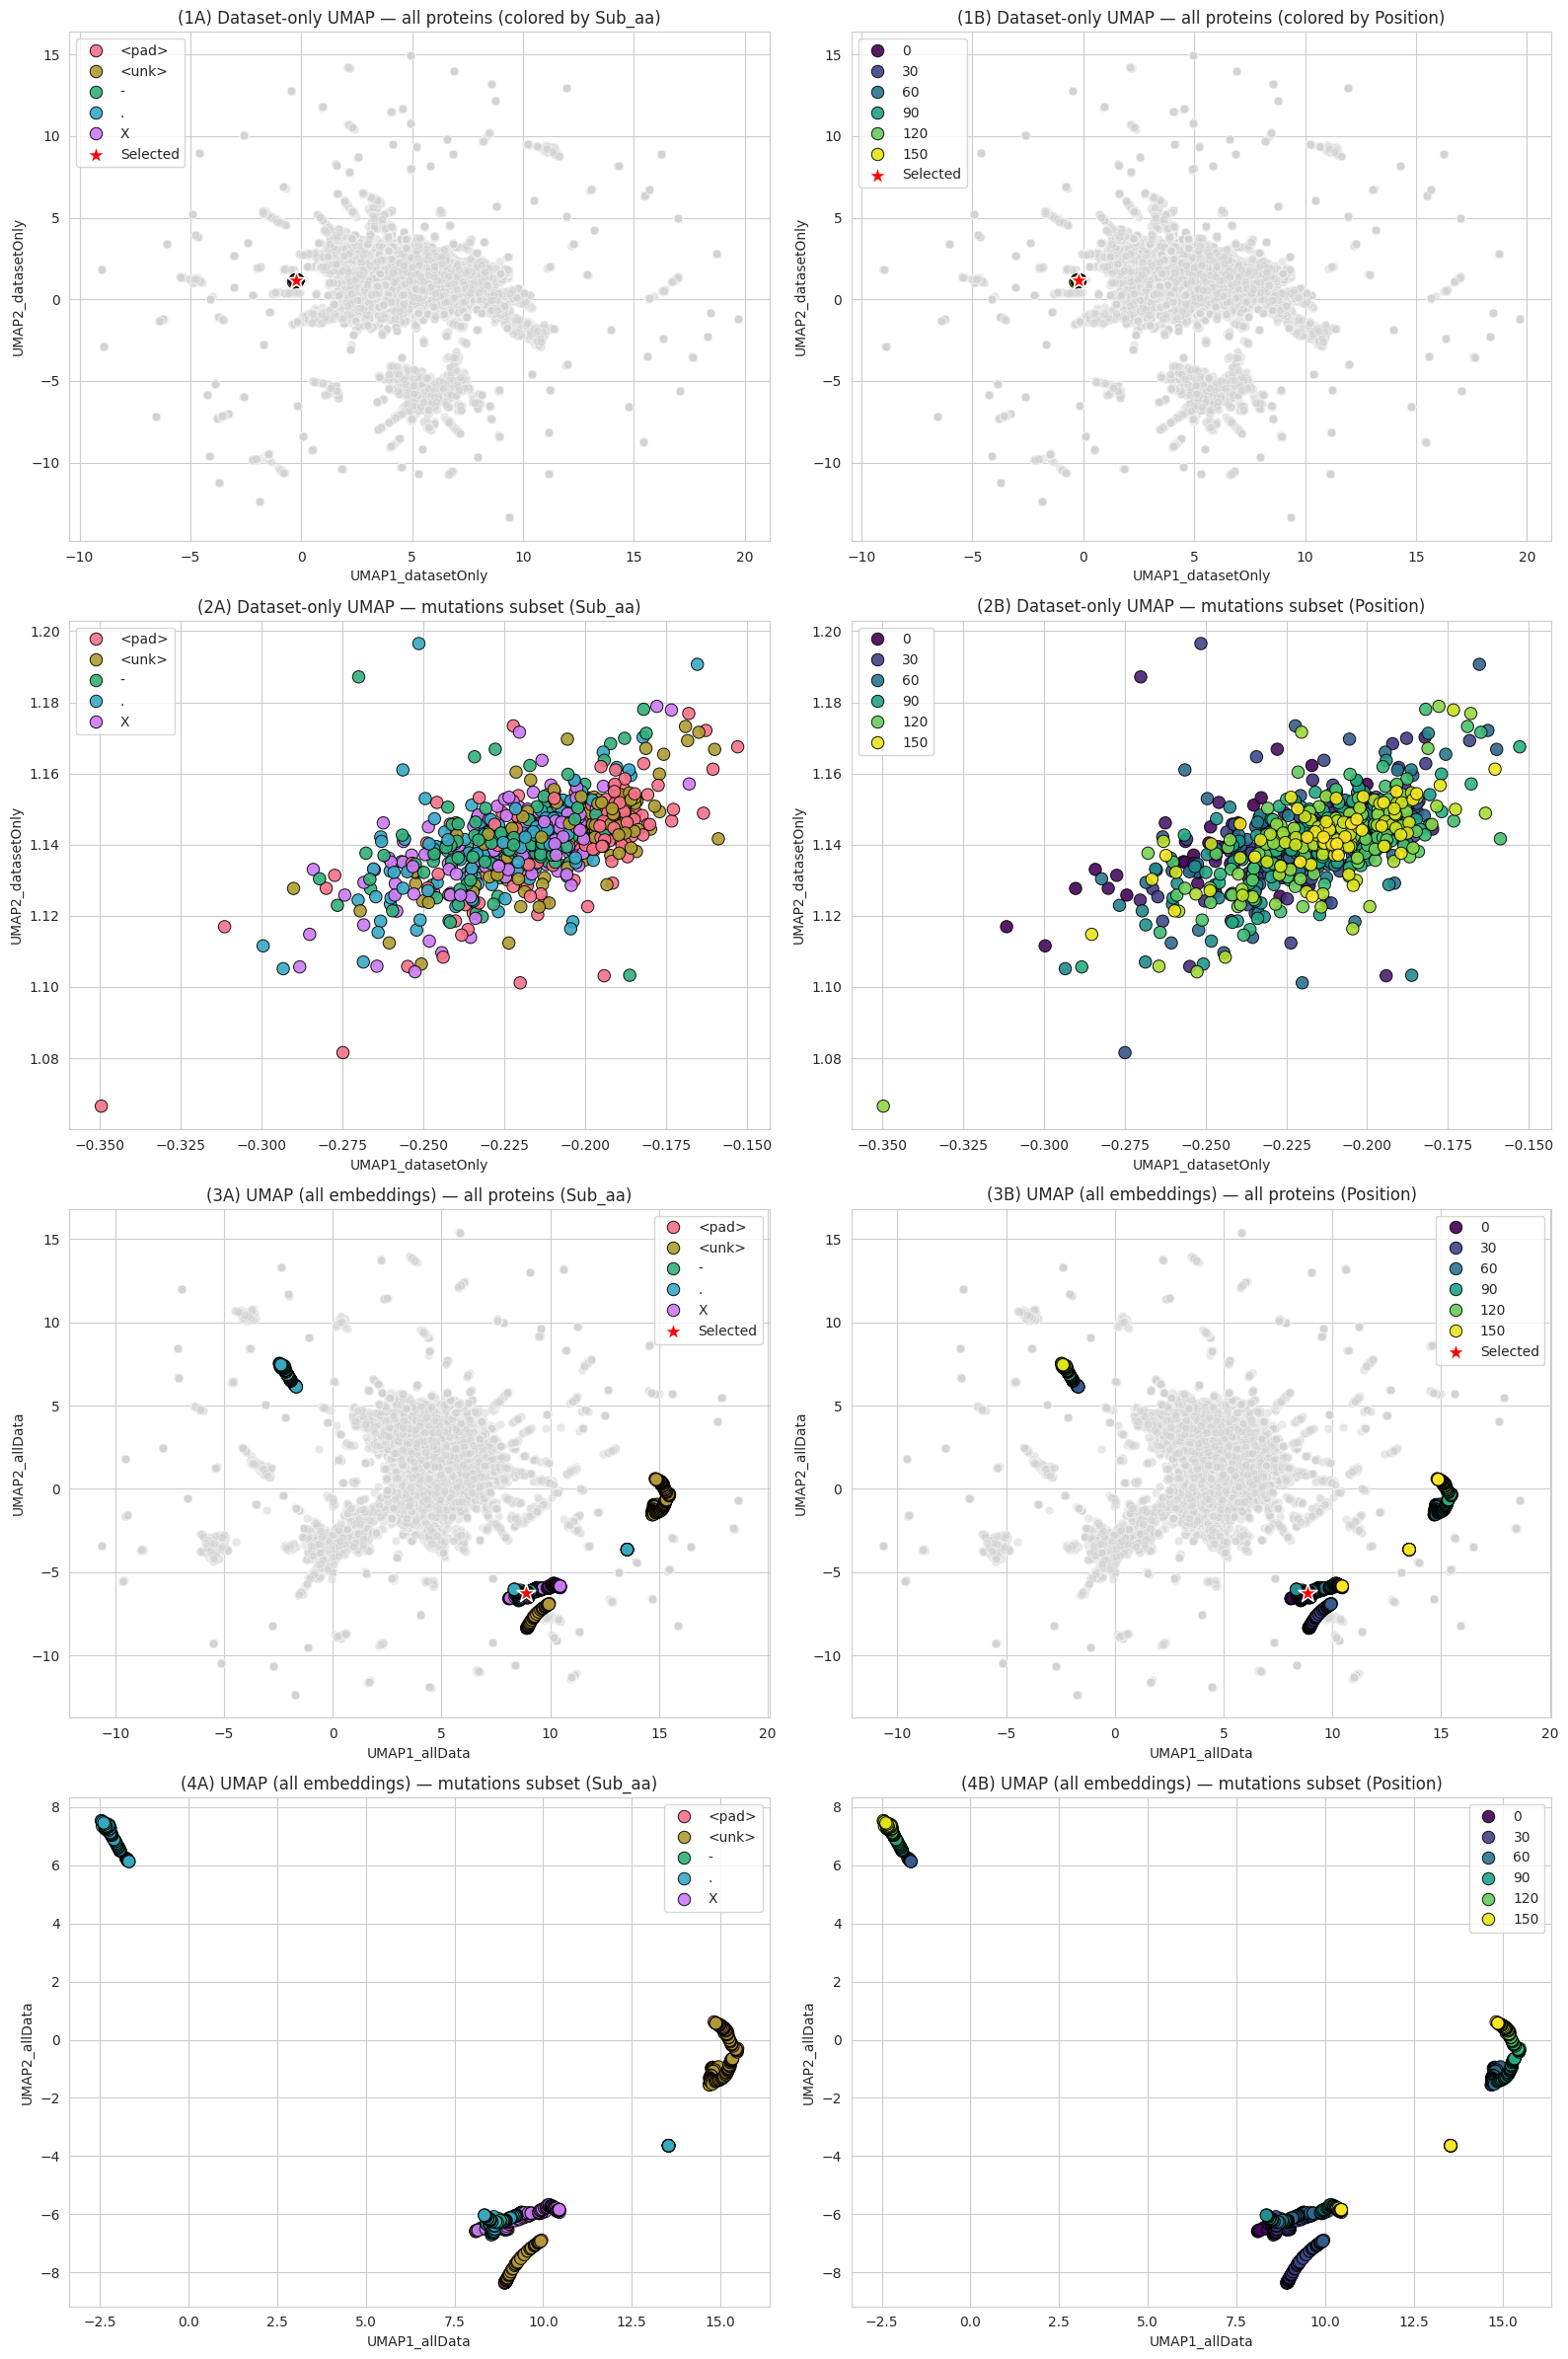

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# General figure setup
fig, axes = plt.subplots(4, 2, figsize=(16, 24))
plt.subplots_adjust(hspace=0.3, wspace=0.25)

# Helper plotting function
def plot_umap(ax, df, x, y, hue, title, palette, show_dataset_bg=True):
    # Optional gray background for dataset
    if show_dataset_bg:
        sns.scatterplot(
            data=df[df["Source"] == "Dataset"],
            x=x, y=y,
            color="lightgrey", s=40, alpha=0.5, ax=ax, label=None
        )
    # Colored scatter
    sns.scatterplot(
        data=df[df["Source"] == "Mutations"],
        x=x, y=y,
        hue=hue,
        palette=palette,
        s=80, alpha=0.9,
        edgecolor="black", ax=ax
    )
    # Highlight selected protein
    sns.scatterplot(
        data=df[df["Source"] == "Selected"],
        x=x, y=y,
        color="red", marker="*", s=200, ax=ax, label="Selected"
    )
    ax.set_title(title, fontsize=12)
    ax.legend(loc="best")

# --------------------------------------------------------
# Row 1: UMAP fit only on dataset (all proteins)
# --------------------------------------------------------
plot_umap(
    axes[0, 0], df_umap_combined,
    "UMAP1_datasetOnly", "UMAP2_datasetOnly",
    hue="Sub_aa", title="(1A) Dataset-only UMAP — all proteins (colored by Sub_aa)",
    palette="husl"
)
plot_umap(
    axes[0, 1], df_umap_combined,
    "UMAP1_datasetOnly", "UMAP2_datasetOnly",
    hue="Position", title="(1B) Dataset-only UMAP — all proteins (colored by Position)",
    palette="viridis"
)

# --------------------------------------------------------
# Row 2: UMAP fit only on dataset (subset: only mutated proteins)
# --------------------------------------------------------
plot_umap(
    axes[1, 0], df_umap_combined[df_umap_combined["Source"] == "Mutations"],
    "UMAP1_datasetOnly", "UMAP2_datasetOnly",
    hue="Sub_aa", title="(2A) Dataset-only UMAP — mutations subset (Sub_aa)",
    palette="husl", show_dataset_bg=False
)
plot_umap(
    axes[1, 1], df_umap_combined[df_umap_combined["Source"] == "Mutations"],
    "UMAP1_datasetOnly", "UMAP2_datasetOnly",
    hue="Position", title="(2B) Dataset-only UMAP — mutations subset (Position)",
    palette="viridis", show_dataset_bg=False
)

# --------------------------------------------------------
# Row 3: UMAP fit on all embeddings (all proteins)
# --------------------------------------------------------
plot_umap(
    axes[2, 0], df_umap_combined,
    "UMAP1_allData", "UMAP2_allData",
    hue="Sub_aa", title="(3A) UMAP (all embeddings) — all proteins (Sub_aa)",
    palette="husl"
)
plot_umap(
    axes[2, 1], df_umap_combined,
    "UMAP1_allData", "UMAP2_allData",
    hue="Position", title="(3B) UMAP (all embeddings) — all proteins (Position)",
    palette="viridis"
)

# --------------------------------------------------------
# Row 4: UMAP fit on all embeddings (subset: only mutated proteins)
# --------------------------------------------------------
plot_umap(
    axes[3, 0], df_umap_combined[df_umap_combined["Source"] == "Mutations"],
    "UMAP1_allData", "UMAP2_allData",
    hue="Sub_aa", title="(4A) UMAP (all embeddings) — mutations subset (Sub_aa)",
    palette="husl", show_dataset_bg=False
)
plot_umap(
    axes[3, 1], df_umap_combined[df_umap_combined["Source"] == "Mutations"],
    "UMAP1_allData", "UMAP2_allData",
    hue="Position", title="(4B) UMAP (all embeddings) — mutations subset (Position)",
    palette="viridis", show_dataset_bg=False
)

plt.tight_layout()
plt.show()


# Positional Bias?

### Generete possible variable sequences

In [ ]:
import os
import torch
import random
import warnings

def generate_positional_bias_tests(wt_seq, max_length=1000):
    """Generate artificial sequences for positional bias testing."""
    tests = {}
    # 1️⃣ Shuffle
    shuffled = list(wt_seq)
    random.shuffle(shuffled)
    tests["shuffle"] = "".join(shuffled)
    # 2️⃣ Reverse
    tests["reverse"] = wt_seq[::-1]
    # 3️⃣ Pad left (simulate left padding)
    pad_token = '<pad>'
    n_pad = min(50, len(wt_seq)//4)
    tests["pad_left"] = (pad_token * n_pad + wt_seq)[:max_length] # still truncate 
    # 4️⃣ Mask N-terminal residues
    masked = list(wt_seq)
    for i in range(min(50, len(masked))):
        masked[i] = "<mask>"
    tests["mask_N"] = "".join(masked)
    # 5️⃣ Random protein
    aas = list("MDVRTKKFCSYWGSDCFKRTFFTRRFGSNYICDMKKFGVFELAMDRWHRWWQNDVHWTQVEPVRFHDRAAQFKVQQLCRGQRMEWMEYGYRDSNVFFDKPITYEAYFEMYVHEATIHFCMKYQSCHTQFLDGRSWCQQHSHLLNYKQGQANQHQCTQCYFFHVAAEVPANDKPKSTMWINEPSSFWWDGSVGHGNTMRVRIQIQAQIFQANCPMDYQVNVHFQDRGVRSHLLERHDTDANEKYVGAVLNVCTCEEDWRQKSHDWWQDTQEQFCAYQLQFFAGNFYGHNKDRSYKANYWDMTWEVFVDVVFVMWDYGTGREFLDHRFHTCPQEDPDMRDNRPSGGGKHGNNHKPIVATADP")
    tests["random"] = "".join(random.choices(aas, k=len(wt_seq)))
    # 6️⃣ Center crop
    if len(wt_seq) > max_length:
        start = (len(wt_seq) - max_length) // 2
        end = start + max_length
        tests["center_crop"] = wt_seq[start:end]
    else:
        tests["center_crop"] = wt_seq
    # 6️⃣ Duplciate satrt at the end
    n = min(50, len(wt_seq)//4)
    tests["repeat_start"] =  ("MAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA" + wt_seq + wt_seq[:n])[:max_length] # still truncate 
    return tests


# =============================
# Generate positional-bias test data
# =============================

print("🔹 Generating positional-bias test sequences...")

wt_seq = selected_protein_data["sequence"][0]
max_len = config["PROTEIN_MAX_LENGTH"]

bias_tests = generate_positional_bias_tests(wt_seq, max_length=max_len)
test_names = list(bias_tests.keys())
test_seqs = list(bias_tests.values())

for k, v in bias_tests.items():
    print(k, "-->", v)

# =============================
# Tokenize
# =============================
print("🔹 Tokenizing test sequences...")

encoded = tokenizer(
    test_seqs,
    padding='max_length',
    max_length=max_len,
    truncation=True,
    return_tensors="pt",
)

# =============================
# Prepare cache dict
# =============================
cache_bias = {
    'protein': test_names,
    'sequence': test_seqs,
    'truncated_sequence': test_seqs,
    'input_ids': encoded["input_ids"],
    'attention_mask': encoded["attention_mask"],
    'embedding': torch.zeros((len(test_seqs), 1), dtype=torch.float32),
    'label': torch.zeros(len(test_seqs), dtype=torch.long),
    'set': torch.zeros((len(test_seqs), 1), dtype=torch.float32),
}

# =============================
# Compute embeddings (using your ESM model)
# =============================

print("🔹 Creating embeddings for bias test sequences...")
out = my_dataset.create_uniprot_embs(
    esm_model=esm_model,
    config=config,
    cache_data=cache_bias,
    num_samples=len(test_seqs),
    emb_dim=config["PRECOMPUTED_EMBS_DIM"]
)

# =============================
# Load embeddings and dataloader
# =============================

embs_bias, bias_names_loaded = out["embs"], out["protein_names"]

cache_bias["embedding"] = embs_bias



🔹 Generating positional-bias test sequences...
shuffle --> RGKEGATGYDNPRDADMQQMYGRSQYGGDVNEEGFSGFRTTSHRRGGMTRVTFNQNIARVSSYRYIDEGYENRKGYSISLSVGVYGGARAGRYGGGPGSYSGHGRDHGVYGYNGHFGSERRRSLFGNRDDNGGRSLGPGFDGANDLFDEQSVEASKF
reverse --> NDYNDRYNGGSYRDYGGQNRGNYDRSRGYGYGYGGPRSDYYRGSGYGQDGGGRSYSRGRGHAGFGGGRTGRASKGAHDVRIQRGDLSEGNMARMAVSAHEPNTFTIFGFGRSRQTERDKVVVVESIPGFSSFHDELAQEDTNFNLGGVFLKGEESSM
pad_left --> <pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad>MSSEEGKLFVGGLNFNTDEQALEDHFSSFGPISEVVVVKDRETQRSRGFGFITFTNPEHASVAMRAMNGESLDGRQIRVDHAGKSARGTRGGGFGAHGRGRSYSRGGGDQGYGSGRYYDSRPGGYGYGYGRSRDYNGRNQGGYDRYSGGNYRDNYDN
mask_N --> <mask><mask><mask><mask><mask><mask><mask><mask><mask><mask><mask><mask><mask><mask><mask><mask><mask><mask><mask><mask><mask><mask><mask><mask><mask><mask><mask><mask><mask><mask><mask><mask><mask><mask><mask><mask><mask><mask><mask><m

Processing protein batches:   0%|          | 0/1 [00:00<?, ?it/s]

Processing protein batches: 100%|██████████| 1/1 [00:12<00:00, 12.20s/it]

Embeddings shape: torch.Size([7, 2560])
✓ Saved 7 embeddings
  Embeddings: None
  Names: None


### Reverse order

In [ ]:
stop

In [ ]:
####################
# Select single biased prot info

selected_bias_cache = my_dataset.subset_data_dict(cache_bias, [6]) # 1 --> reverse
selected_bias_emb=selected_bias_cache["embedding"]
type_bias=selected_bias_cache["protein"][0]
print(type_bias)
print(selected_bias_cache.keys())

####################
# create all mutatios

all_biased_mutated_seqs, biased_mutation_names = my_scanning.create_all_mutations(selected_bias_cache["truncated_sequence"][0], WINDOW_SIZE_SUBSTITUION, SUBSTITUTE_AA)
tot_mutations = len(all_biased_mutated_seqs)
print(tot_mutations,  len(list(selected_bias_cache["truncated_sequence"][0])) * len(SUBSTITUTE_AA))
print(all_biased_mutated_seqs[:1])

####################
# tokenize allmtuations

# ATTNETION: alredy truncated
print("Tokenizing...")
encoded = tokenizer(
    all_biased_mutated_seqs,
    padding='max_length',
    max_length=config["PROTEIN_MAX_LENGTH"],
    truncation=True,
    return_tensors="pt"
)

####################
# make cache data

cache_mutations_biased = {
    'protein': biased_mutation_names,
    'sequence': all_biased_mutated_seqs,
    'truncated_sequence': all_biased_mutated_seqs, # alredy trucnated
    'input_ids': encoded["input_ids"],
    'attention_mask': encoded["attention_mask"],

    'embedding': torch.zeros((tot_mutations, 1), dtype=torch.float32), # FAKE
    'label': torch.zeros(tot_mutations, dtype=torch.long), # FAKE
    'set': torch.zeros((tot_mutations, 1), dtype=torch.float32), # FAKE
}
display(cache_mutations_biased["truncated_sequence"][:10])
print(np.array(cache_mutations_biased["input_ids"][:10, :10]))

####################
# Save mutations embs

biased_mutations_embs_path = os.path.join(
    os.path.dirname(config["PRECOMPUTED_EMBS_PATH"]),
    "single_prot_mutations",
    f"{PROTEIN}_biased_{type_bias}_[{'_'.join(SUBSTITUTE_AA)}]_{WINDOW_SIZE_SUBSTITUION}_{config['PRETRAIN_ESM_CHECKPOINT_NAME'].replace('/', '-')}_{config['TYPE_EMB_FOR_CLASSIFICATION']}.safetensors"
)
biased_mutations_names_path=biased_mutations_embs_path.replace('.safetensors', '_names.json')

if not os.path.exists(biased_mutations_embs_path):
    my_dataset.create_uniprot_embs(
        esm_model=esm_model,
        config=config, 
        cache_data=cache_mutations_biased, 
        num_samples=tot_mutations, 
        save_embs_path=biased_mutations_embs_path,
        save_names_path=biased_mutations_names_path,
        emb_dim=config["PRECOMPUTED_EMBS_DIM"]
    )

embs_biased_mutations, protein_biased_names_selected = my_dataset.load_embs_safetensor(
    precomputed_embs_path=biased_mutations_embs_path, # path with tensors
    protein_names_path=biased_mutations_names_path, # path with the prtein names of the tenoser
    protein_to_select=None # take all
)

cache_mutations_biased["embedding"] = embs_biased_mutations

#check
print(protein_biased_names_selected == cache_mutations_biased["protein"])

####################
# Make dataloder
mutations_dl_biased = my_dataset.create_dataloader(cache_mutations_biased, config["BATCH_SIZE"], shuffle=False) 
names_mutations_biased = cache_mutations_biased["protein"]


repeat_start
dict_keys(['protein', 'label', 'set', 'sequence', 'truncated_sequence', 'input_ids', 'attention_mask', 'embedding'])


Generating mutations: 100%|██████████| 263/263 [00:00<00:00, 45138.80it/s]

1315 1315
['<pad><pad><pad>AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAMSSEEGKLFVGGLNFNTDEQALEDHFSSFGPISEVVVVKDRETQRSRGFGFITFTNPEHASVAMRAMNGESLDGRQIRVDHAGKSARGTRGGGFGAHGRGRSYSRGGGDQGYGSGRYYDSRPGGYGYGYGRSRDYNGRNQGGYDRYSGGNYRDNYDNMSSEEGKLFVGGLNFNTDEQALEDHFSSFGPISEVVVVK']
Tokenizing...


['<pad><pad><pad>AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAMSSEEGKLFVGGLNFNTDEQALEDHFSSFGPISEVVVVKDRETQRSRGFGFITFTNPEHASVAMRAMNGESLDGRQIRVDHAGKSARGTRGGGFGAHGRGRSYSRGGGDQGYGSGRYYDSRPGGYGYGYGRSRDYNGRNQGGYDRYSGGNYRDNYDNMSSEEGKLFVGGLNFNTDEQALEDHFSSFGPISEVVVVK',
 '<unk><unk><unk>AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAMSSEEGKLFVGGLNFNTDEQALEDHFSSFGPISEVVVVKDRETQRSRGFGFITFTNPEHASVAMRAMNGESLDGRQIRVDHAGKSARGTRGGGFGAHGRGRSYSRGGGDQGYGSGRYYDSRPGGYGYGYGRSRDYNGRNQGGYDRYSGGNYRDNYDNMSSEEGKLFVGGLNFNTDEQALEDHFSSFGPISEVVVVK',
 '---AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAMSSEEGKLFVGGLNFNTDEQALEDHFSSFGPISEVVVVKDRETQRSRGFGFITFTNPEHASVAMRAMNGESLDGRQIRVDHAGKSARGTRGGGFGAHGRGRSYSRGGGDQGYGSGRYYDSRPGGYGYGYGRSRDYNGRNQGGYDRYSGGNYRDNYDNMSSEEGKLFVGGLNFNTDEQALEDHFSSFGPISEVVVVK',
 '...AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAMSSEEGKLFVGGLNFNTDEQALEDHFSSFGPISEVVVVKDRETQRSRGFGFITFTNPEHASVAMRAMNGESLDGRQIRVDHAGKSARGTRGGGFGAHGRGRSY

/tmp/ipykernel_542940/989421936.py:46: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  print(np.array(cache_mutations_biased["input_ids"][:10, :10]))


[[ 0  1  1  1  5  5  5  5  5  5]
 [ 0  3  3  3  5  5  5  5  5  5]
 [ 0 30 30 30  5  5  5  5  5  5]
 [ 0 29 29 29  5  5  5  5  5  5]
 [ 0 24 24 24  5  5  5  5  5  5]
 [ 0  1  1  1  1  5  5  5  5  5]
 [ 0  3  3  3  3  5  5  5  5  5]
 [ 0 30 30 30 30  5  5  5  5  5]
 [ 0 29 29 29 29  5  5  5  5  5]
 [ 0 24 24 24 24  5  5  5  5  5]]


Processing protein batches:   6%|▌         | 5/83 [02:55<45:44, 35.19s/it]


KeyboardInterrupt: 

In [ ]:
##############################
# calcualte baseline prob

wt_biased_dl = my_dataset.create_dataloader(selected_bias_cache, batch_size=1, shuffle=False) 
wt_biased_dict = mf.evaluate_model(
            net=net, 
            dl=wt_biased_dl,
            device=config["DEVICE"], 
            loss_fn=net.loss_fn,
            split_name="WT prot", 
            verbose=False,
            from_precomputed_embs=True
        )
baseline_prob = float(wt_biased_dict["probs_class1"][0])
print(baseline_prob)

##############################
# calculate prob for each utation

scan_results_biased = my_scanning.multi_aa_scanning_tmp(
    model=net,
    baseline_prob=baseline_prob,
    mutations_dl=mutations_dl_biased,
    names_mutations=names_mutations_biased,
    substitute_aas=SUBSTITUTE_AA,
    wt_seq=selected_bias_cache["truncated_sequence"][0],
    prot_name=PROTEIN, 
    device=config["DEVICE"], 
)
#scan_results

Evaluation:   0%|          | 0/1 [00:00<?, ? WT prot batch/s]

0.13021573424339294


/home/gdallagl/.pyenv/versions/esm2_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:534: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/home/gdallagl/.pyenv/versions/esm2_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:534: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/home/gdallagl/.pyenv/versions/esm2_env/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


Evaluation:   0%|          | 0/3 [00:00<?, ? mutations batch/s]

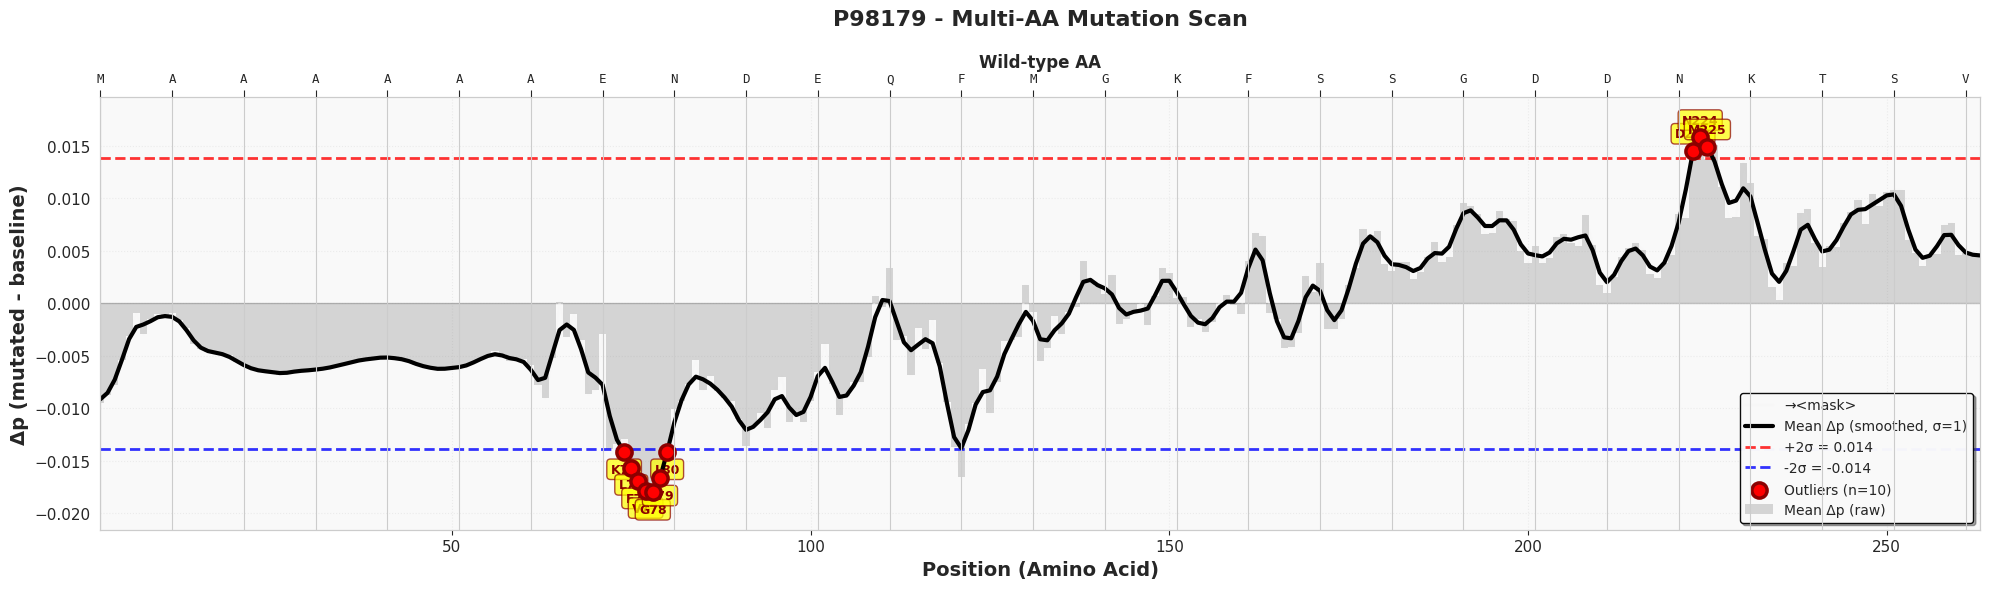

Outlier positions (|Δp| > 2σ):
  Position  74 (K): Δp = -0.0141
  Position  75 (L): Δp = -0.0156
  Position  76 (F): Δp = -0.0169
  Position  77 (V): Δp = -0.0178
  Position  78 (G): Δp = -0.0180
  Position  79 (G): Δp = -0.0166
  Position  80 (L): Δp = -0.0141
  Position 223 (D): Δp = +0.0145
  Position 224 (N): Δp = +0.0158
  Position 225 (M): Δp = +0.0149



In [ ]:
my_scanning.plot_multi_aa_scan(scan_results_biased, sigma=1,figsize=(20, 6), 
                        palette='RdBu_r', show_per_aa=True)#, xlim=[0,50])


# AAAAAAAAAAAAAAAAAAAAAAAAAAAAAA
# AAAAAAAAAAAAAAAAAAAAAAAAAAAAAA

### A-scanning Logits

In [ ]:
def prob_to_logit(p):
    """
    Convert probability of class 1 to logit (binary case)
    p: float or np.array of probabilities (0 < p < 1)
    returns: logit value(s)
    """
    p = np.clip(p, 1e-15, 1 - 1e-15)  # avoid log(0)
    return np.log(p / (1 - p))


PROTEIN = "P05997" #"Q6ZRI0" #"P01270" #"O60938" #"P05997"
WINDOW_SIZE_FRACTION = 0.01 # 10% of sequence length
SUBSTITUTE_AA = "A" #"<pad>", "A", "P"

# Extract info
single_protein_info = data_df[data_df['protein'] == PROTEIN].iloc[0]
display(single_protein_info)

WINDOW_SIZE_SUBSTITUION = int(single_protein_info.trunc_sequence_length * WINDOW_SIZE_FRACTION // 2 * 2 + 1) # make it odd
print(WINDOW_SIZE_SUBSTITUION)

# Run alanine scanning
results = mf.alanine_scanning(
    model=net,
    tokenizer=tokenizer,
    single_protein_info=single_protein_info,
    window_size=WINDOW_SIZE_SUBSTITUION, # make it odd
    device=config["DEVICE"],
    SUBSTITUTE_AA=SUBSTITUTE_AA,
    normalise_true_substitution=True #normalise by number of true substitutions (not A->A
)

# calcuate logits
baseline_logit = prob_to_logit(results['baseline_prob'])
mutated_logits = prob_to_logit(results['mutated_probs'])
delta_logit = mutated_logits - baseline_logit

mf.plot_alanine_scan(
    delta_p=delta_logit,
    sequence=results['sequence'],
    protein_name=results['protein_name'],
    sigma=3,
    threshold=True,
    highlight_residues=True,
    top_n=10,
    show_sequence=False,
    style='whitegrid'  # Options: 'darkgrid', 'whitegrid', 'dark', 'white', 'ticks'
)

NameError: name 'data_df' is not defined

### Random prot

In [ ]:
random_prot = "MVMAAAKKNMQQLDSFKGDDSIDHEIATPYSWQRKFSGESKAIALGMYGTKMISCGQWRDQACYILYWVFWYPYFNVSQESIVLQYDLPHYGYDIFKPYINQTARCCPHHPQEAMNSEGNTVPACYAAVGQADPPIFDIAYSIMILRPLYGTCNPTGFQNVMNAIWSEEMAMFTQTHYVLPYRYPYQTYRLTSFSSRIMMENAGACEWESMVNFIFRTVAKRCKDKEYLFGNCAWTRLWSIAPHQWKWPSKNTHMYIDHFVEKGKQEELSNASWHTYLATSICPAHHHDWVWWNFEFWLCHFTEMDT"
random_label = 0
random_name = "Random_Prot"
random_data = pd.DataFrame([{
    'sequence': random_prot,
    'label': random_label,
    'protein': random_name,
    'set': 'test'
}])

# Preprocess each sequence individually
random_preprocessed_data = []
for idx, row in tqdm(random_data.iterrows(), total=len(random_data)):
    processed = my_dataset.preprocess_sequence(
        sequence=row['sequence'],
        label=row['label'],
        protein_name=row['protein'],
        tokenizer=tokenizer,
        protein_max_length=config["PROTEIN_MAX_LENGTH"]
    )
    random_preprocessed_data.append(processed)

# Create DataFrame from preprocessed data
random_data_df = pd.DataFrame(random_preprocessed_data)

# Add the 'set' column back from original data
random_data_df['set'] = random_data['set'].values

############################################

random_dl = my_dataset.create_dataloader(random_data_df, 'test', config["BATCH_SIZE"], shuffle=True)

# Optional: inspect the DataFrame
display(random_data_df.head(5))
#print(random_data_df.loc[0, "input_ids"])

In [ ]:
outputs = mf.evaluate_model(net, random_dl, config["DEVICE"], loss_fn=None, split_name="Eval", verbose=True)
outputs

### Calibration

In [ ]:
outputs = mf.evaluate_model(net, test_dl, config["DEVICE"], loss_fn=loss_fn, split_name="Eval", verbose=True)
outputs

In [ ]:
probs = outputs['probs_class1']
print(probs)
sns.histplot(probs, kde=False, bins=30)  # kde=True if you also want a density curve
plt.show()

In [ ]:
# Calibration curve

from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt

# y_true: 0 or 1 labels for your proteins
# y_prob: predicted probabilities for class 1

#x-axis = average predicted probability in that bin.
#y-axis = true fraction positive in that bin.

prob_true, prob_pred = calibration_curve(y_true=outputs['labels'], y_prob=outputs['probs_class1'], n_bins=10)

plt.plot(prob_pred, prob_true, marker='o', label="Model")
plt.plot([0,1],[0,1], linestyle="--", label="Perfect calibration")
plt.xlabel("Predicted probability")
plt.ylabel("True fraction positive")
plt.title("Reliability diagram")
plt.legend()
plt.show()
